In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import pickle
from Bio.Seq import Seq
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, to_hex
from matplotlib import collections  as mc
from scipy.special import expit
import torch
from collections import defaultdict

# DMS data

Single mutant scores

In [3]:
dms_df = pd.read_csv("../results/final_variant_scores/final_variant_scores.csv", dtype=dict(position_IMTG=pd.Int16Dtype()))
# remove linker sites
dms_df = dms_df[dms_df.chain != "link"]
# add indicator for wildtype data
dms_df["WT"] = dms_df.wildtype == dms_df.mutant
assert dms_df.position_IMTG.max() < 1000
dms_df["site"] = [f"{chain}-{str(pos).zfill(3)}" for chain, pos in zip(dms_df.chain, dms_df.position_IMTG)]
dms_df

target wildtype  position  position_IMTG chain mutant  mutation  \
0     CGG_naive        E         1              1     H      A    E1(H)A   
1     CGG_naive        E         1              1     H      C    E1(H)C   
2     CGG_naive        E         1              1     H      D    E1(H)D   
3     CGG_naive        E         1              1     H      E    E1(H)E   
4     CGG_naive        E         1              1     H      F    E1(H)F   
...         ...      ...       ...            ...   ...    ...       ...   
4695  CGG_naive        R       235            124     L      S  R124(L)S   
4696  CGG_naive        R       235            124     L      T  R124(L)T   
4697  CGG_naive        R       235            124     L      V  R124(L)V   
4698  CGG_naive        R       235            124     L      W  R124(L)W   
4699  CGG_naive        R       235            124     L      Y  R124(L)Y   

     codon single_nt      bind  ...      expr  delta_expr  n_bc_expr  \
0      GAG      True  10.48829  ...  10.44614    -0.00453       19.0   
1      GAG     False  10.44477  ...  10.32364    -0.12703       20.0   
2      GAG      True  10.42771  ...  10.51618     0.06551       16.0   
3      GAG      True  10.45719  ...  10.45067     0.00000    21170.0   
4      GAG     False  10.51899  ...  10.33163    -0.11904       24.0   
...    ...       ...       ...  ...       ...         ...        ...   
4695   CGT      True  10.44756  ...  10.54313     0.09246       39.0   
4696   CGT     False  10.43023  ...  10.53860     0.08793       36.0   
4697   CGT     False  10.38231  ...  10.48707     0.03640       27.0   
4698   CGT     False  10.48219  ...  10.38698    -0.06369       33.0   
4699   CGT     False  10.47297  ...  10.48454     0.03387       34.0   

      n_libs_expr      psr  delta_psr  n_bc_psr  n_libs_psr     WT   site  
0             2.0  6.78608   -0.07452      17.0         2.0  False  H-001  
1             2.0  7.44234    0.58174      17.0         2.0  False  H-001  
2             2.0  6.95940    0.09880      13.0         2.0  False  H-001  
3             2.0  6.86060    0.00000   18910.0         2.0   True  H-001  
4             2.0  6.91372    0.05313      21.0         2.0  False  H-001  
...           ...      ...        ...       ...         ...    ...    ...  
4695          2.0  6.93925    0.07866      33.0         2.0  False  L-124  
4696          2.0  6.88956    0.02896      34.0         2.0  False  L-124  
4697          2.0  6.78160   -0.07899      24.0         2.0  False  L-124  
4698          2.0  6.91474    0.05415      29.0         2.0  False  L-124  
4699          2.0  6.96378    0.10318      32.0         2.0  False  L-124  

[4400 rows x 23 columns]

In [214]:
tree.tree.sequence[:igk_idx]

'GAGGTGCAGCTTCAGGAGTCAGGACCTAGCCTCGTGAAACCTTCTCAGACTCTGTCCCTCACCTGTTCTGTCACTGGCGACTCCATCACCAGTGGTTACTGGAACTGGATCCGGAAATTCCCAGGGAATAAACTTGAGTACATGGGGTACATAAGCTACAGTGGTAGCACTTACTACAATCCATCTCTCAAAAGTCGAATCTCCATCACTCGAGACACATCCAAGAACCAGTACTACCTGCAGTTGAATTCTGTGACTACTGAGGACACAGCCACATATTACTGTGCAAGGGACTTCGATGTCTGGGGCGCAGGGACCACGGTCACCGTCTCCTCA'

Position maps for scFv

In [4]:
pos_df = pd.read_csv("../data/CGGnaive_sites.csv", dtype=dict(site=pd.Int16Dtype()))
pos_df

site_scFv amino_acid chain  site KI_codon
0            1          E     H     1      GAG
1            2          V     H     2      GTG
2            3          Q     H     3      CAG
3            4          L     H     4      CTT
4            5          Q     H     5      CAG
..         ...        ...   ...   ...      ...
230        231          L     L   120      CTA
231        232          E     L   121      GAA
232        233          I     L   122      ATA
233        234          K     L   123      AAA
234        235          R     L   124      CGT

[235 rows x 5 columns]

In [5]:
igh_pos_map = pos_df[pos_df.chain == "H"]
igk_pos_map = pos_df[pos_df.chain == "L"].reset_index(drop=True)

## Heatmaps indicating inaccessible first-step mutations

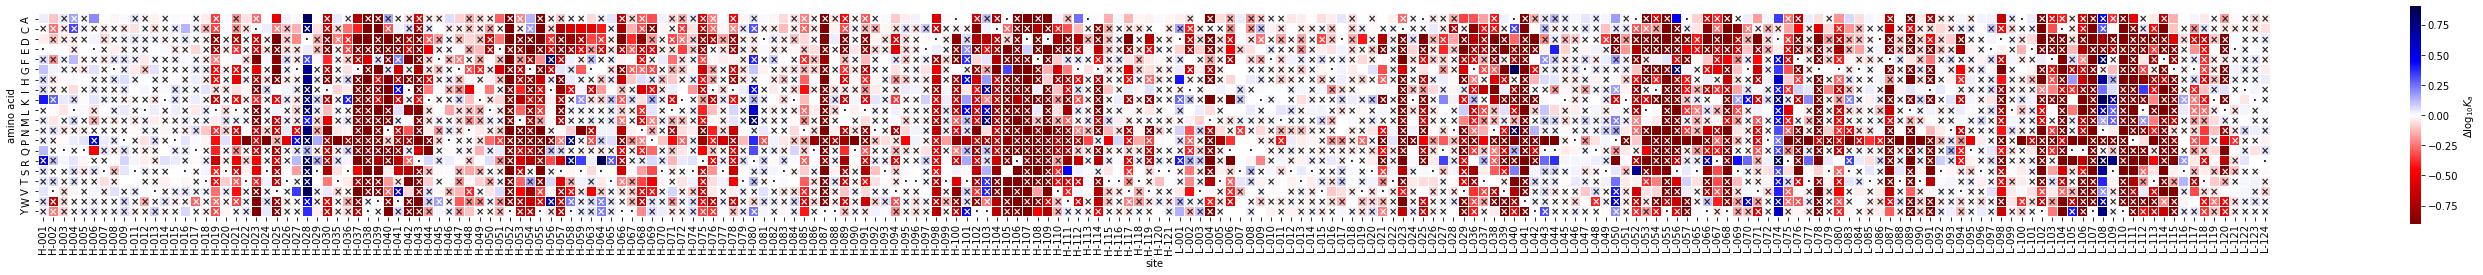

In [167]:
bind_df = dms_df.pivot(index="mutant", columns="site", values="delta_bind")

accessible_df = dms_df.pivot(index="mutant", columns="site", values="single_nt")
wt_df = dms_df.pivot(index="mutant", columns="site", values="WT")

annot = pd.DataFrame(np.empty_like(bind_df, dtype=str), index=bind_df.index, columns=bind_df.columns)
annot.iloc[wt_df.values.astype(bool)] = "\u00B7"
annot.iloc[~accessible_df.values.astype(bool)] = "\u00D7"

vmax = dms_df.delta_bind.max()
vmin = -vmax

plt.figure(figsize=(50, 4))
sns.heatmap(bind_df, center=0, vmin=vmin, vmax=vmax, annot=annot, fmt="", annot_kws=dict(fontweight="bold"),
            cmap="seismic_r", cbar_kws=dict(label=r"$\Delta\log_{10} K_a$"), linewidths=.1, square=True)
plt.xlabel("site")
plt.ylabel("amino acid")
plt.savefig("output/plots/bind_heatmap.pdf")
plt.show()

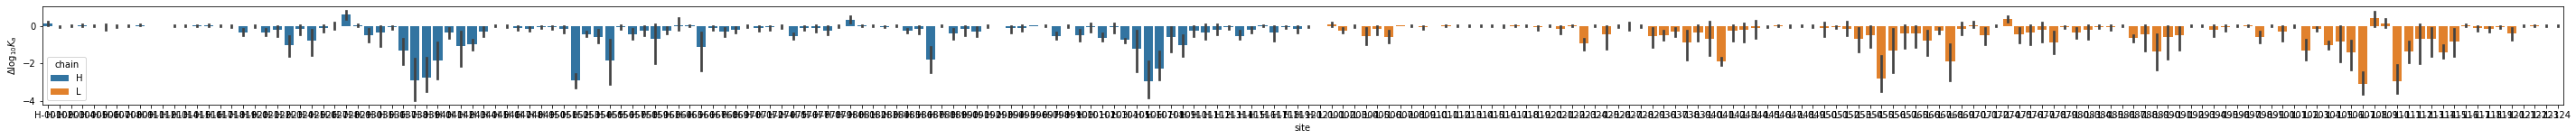

In [7]:
plt.figure(figsize=(50, 2))
sns.barplot(data=dms_df[(~dms_df.WT) & dms_df.single_nt], x="site", y="delta_bind", hue="chain", dodge=False)
plt.ylabel(r"$\Delta\log_{10} K_a$")
plt.savefig("output/plots/bind_boxplot.pdf")
plt.show()

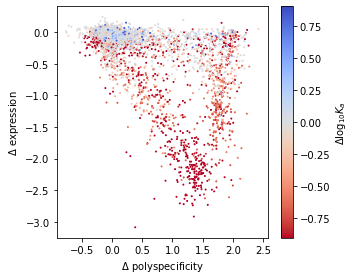

In [168]:
order = np.argsort(dms_df.delta_bind)

plt.figure(figsize=(5, 4))
plt.scatter(dms_df.delta_psr.iloc[order], dms_df.delta_expr.iloc[order], c=dms_df.delta_bind.iloc[order], s=1, cmap="coolwarm_r", vmin=vmin, vmax=vmax)
plt.xlabel(r"$\Delta$ polyspecificity")
plt.ylabel(r"$\Delta$ expression")
plt.colorbar(label=r"$\Delta\log_{10}K_a$")
plt.tight_layout()
plt.savefig("output/plots/3Dscatter.pdf")
plt.show()

# Replay tree data

In [8]:
trees = {f.split("/")[2]: pickle.load(open(f, "rb")) for f in glob.glob("data/*/*/gctree.out.inference.1.p")}

In [9]:
igh_frame = 1
igk_frame = 1
igk_idx = 336

In [10]:
def local_branching(tree, τ=1, τ0=0.1):
    r"""Add local branching statistics (Neher et al. 2014) as tree node
    features to the ETE tree attribute of a ``gctree.CollapsedTree`` object.
    
    Args:
        τ: decay timescale
        τ0: effective branch length for branches with zero mutations
    """
    # the fixed integral contribution for clonal cells indicated by abundance annotations
    clone_contribution = τ * (1 - np.exp(-τ0 / τ))

    # post-order traversal to populate downward integral for each node
    for node in tree.tree.traverse(strategy="postorder"):
        if node.is_leaf():
            node.add_feature("LB_down", node.abundance * clone_contribution
                                        if node.abundance > 1 else 0
                            )
        else:
            node.add_feature("LB_down",
                             node.abundance * clone_contribution
                             + sum(τ * (1 - np.exp(-child.dist / τ))
                                   + np.exp(-child.dist / τ) * child.LB_down
                                   for child in node.children)
                            )

    # pre-order traversal to populate upward integral for each node
    for node in tree.tree.traverse(strategy="preorder"):
        if node.is_root():
            node.add_feature("LB_up", 0)
        else:
            node.add_feature("LB_up",
                             τ * (1 - np.exp(-node.dist / τ))
                             + np.exp(-node.dist / τ) * (node.up.LB_up + node.up.LB_down)
                            )

    # finally, compute LBI (LBR) as the sum (ratio) of upward and downward integrals at each node
    for node in tree.tree.traverse():
        node.add_feature("LBI", node.LB_down + node.LB_up)
        node.add_feature("LBR", node.LB_down / node.LB_up if not node.is_root() else np.nan)

In [11]:
def aa(seq, frame):
    return Seq(seq[(frame - 1) : (frame - 1 + (3 * ((len(seq) - (frame - 1)) // 3)))]).translate()

# def mutations(naive_aa, aa, pos_map, chain_annotation):
#     return [f"{aa1}{pos_map[pos]}{chain_annotation}{aa2}"
#             for pos, (aa1, aa2) in enumerate(zip(naive_aa, aa))
#             if aa1 != aa2]

def tree_nt_seq_to_dms_aa_seq(sequence):

    igh_aa = aa(sequence[:igk_idx], igh_frame)
    igk_aa = aa(sequence[igk_idx:], igk_frame)

    aa_dms = pos_df.amino_acid.copy()
    aa_dms.iloc[pos_df.chain == "H"] = igh_aa
    # note: replay light chains are shorter than dms seq by one aa
    aa_dms.iloc[(pos_df.chain == "L") & (pos_df.index < pos_df.index[-1])] = igk_aa
    
    return "".join(aa_dms)

In [12]:
tdms_model = torch.load("data/mse.model")
tdms_model.eval()

FullyConnected(
  (latent_layer): Linear(in_features=4935, out_features=2, bias=False)
  (nonlinearity_1): Linear(in_features=2, out_features=5, bias=True)
  (output_layer): Linear(in_features=5, out_features=2, bias=True)
)

In [92]:
# Using this as a hack for now to deal with tdms bias problem
tdms_prediction_naive = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(trees["gc31HK"].tree.sequence))).detach()
tdms_prediction_naive

tensor([-0.1611,  0.2952])

In [93]:
# trees_df = pd.DataFrame()

for gc, tree in trees.items():
    
    # rename tuple names with last element of tuple (possible danger)
    if isinstance(tree.tree.name, tuple):
        tree.tree.name = tree.tree.name[-1]
    
    local_branching(tree)

#     naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
#     naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)

    for node in tree.tree.traverse():

#         igh_aa = aa(node.sequence[:igk_idx], igh_frame)
#         igk_aa = aa(node.sequence[igk_idx:], igk_frame)
#         igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map.site, "(H)")
#         igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map.site, "(L)")        
#     

        tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(node.sequence))).detach() - tdms_prediction_naive

        node.add_feature("delta_bind", tdms_prediction[0].item())
        node.add_feature("delta_expr", tdms_prediction[1].item())
    
#         # new_row = dms_df.loc[dms_df.mutation.isin(igh_mutations + igk_mutations), ["delta_bind", "delta_expr", "delta_psr"]].sum()
#         new_row = pd.Series({"delta_bind": node.delta_bind,
#                              "delta_expr": node.delta_expr,
#                              "GC": gc,
#                              "node": node.name,
#                              "parent": node.up.name if node.up is not None else None,
#                              "abundance": node.abundance,
#                              "branch length from naive": tree.tree.get_distance(node),
#                              "LBI": node.LBI,
#                              "LBR": node.LBR
#                              })

        
#         trees_df = trees_df.append(new_row, ignore_index=True, verify_integrity=True)

# trees_df.set_index(["GC", "node"], inplace=True)

# trees_df.to_csv("output/integrated_data.csv")
# trees_df

## Color map $\Delta\log_{10} K_a$ on trees

- Warm colors indicate $\Delta\log_{10} K_a < 0$
- Cool colors indicate $\Delta\log_{10} K_a > 0$

gc31HK


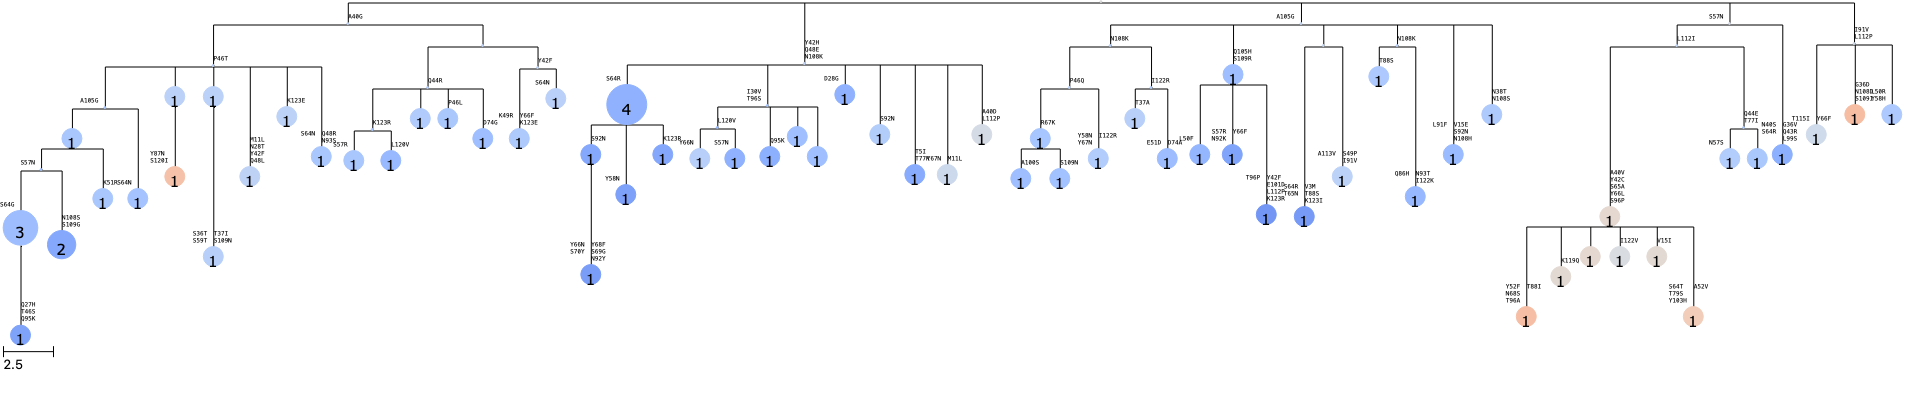

gc50HK


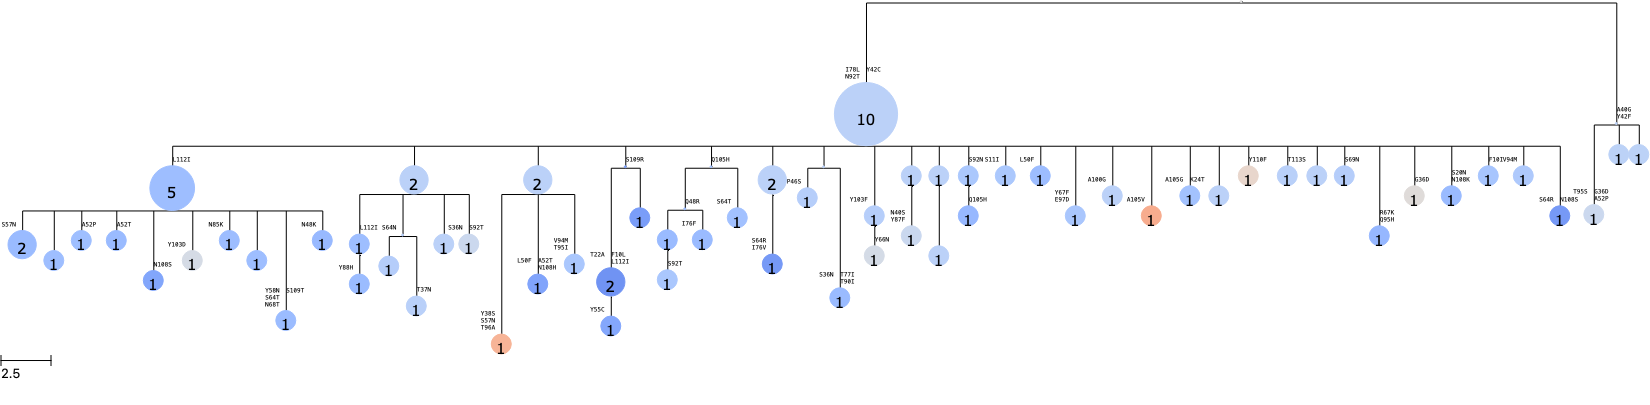

gc59HK


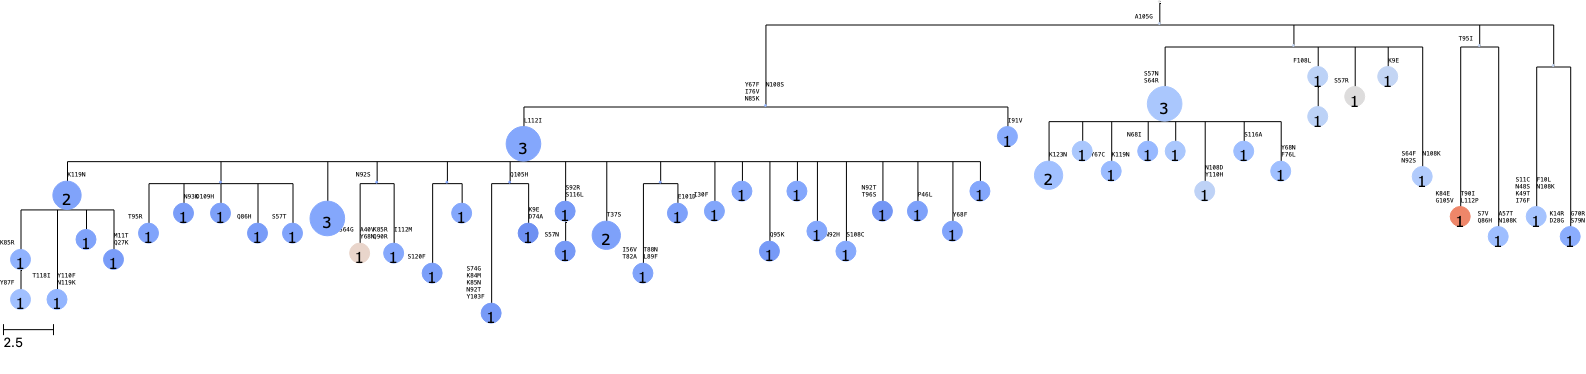

gc17HK


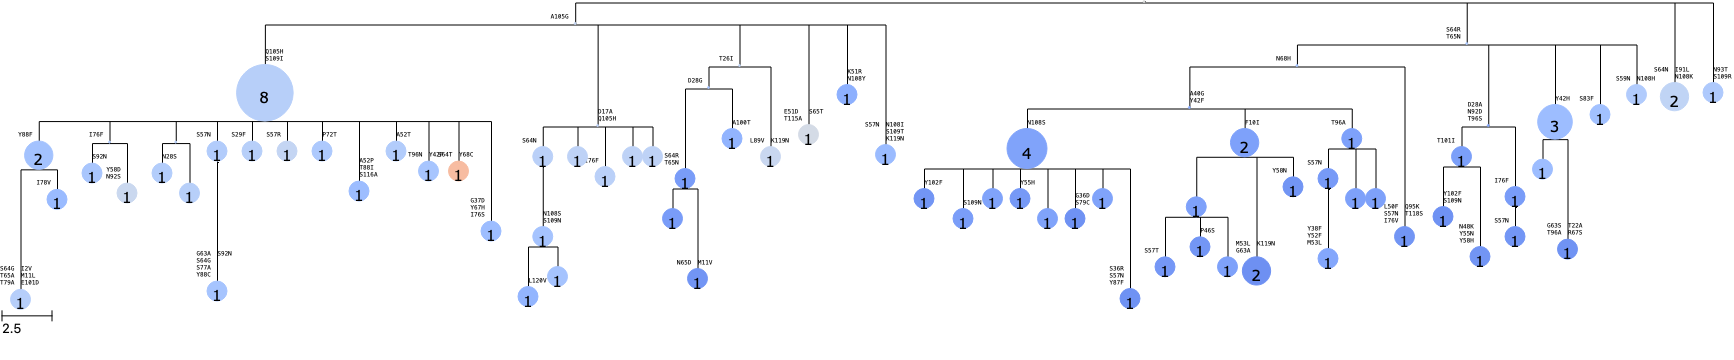

gc56HK


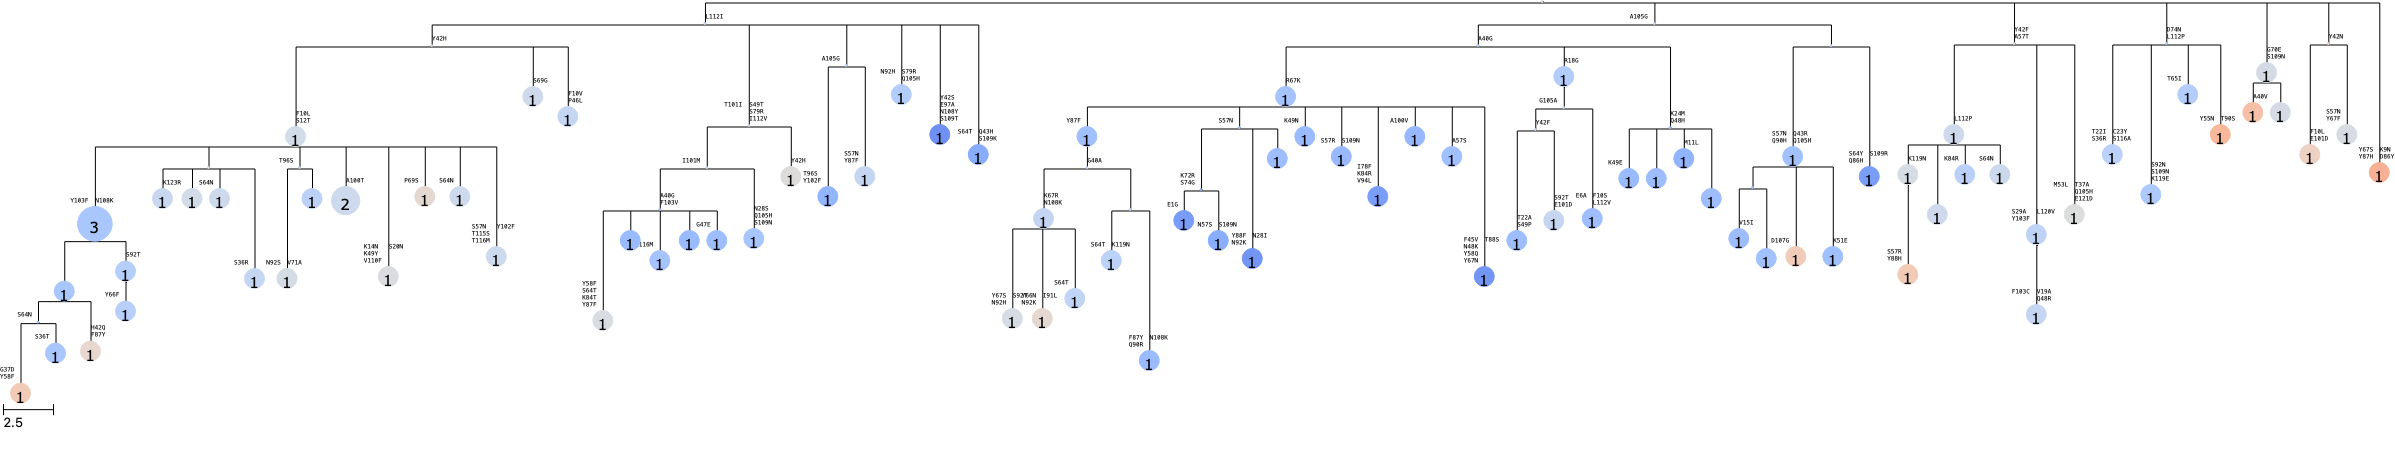

gc39HK


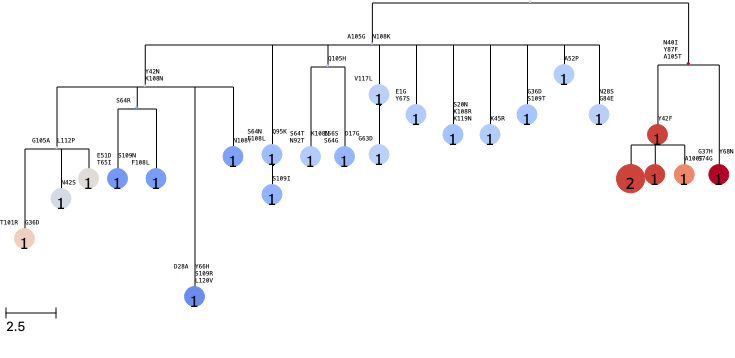

gc77HK


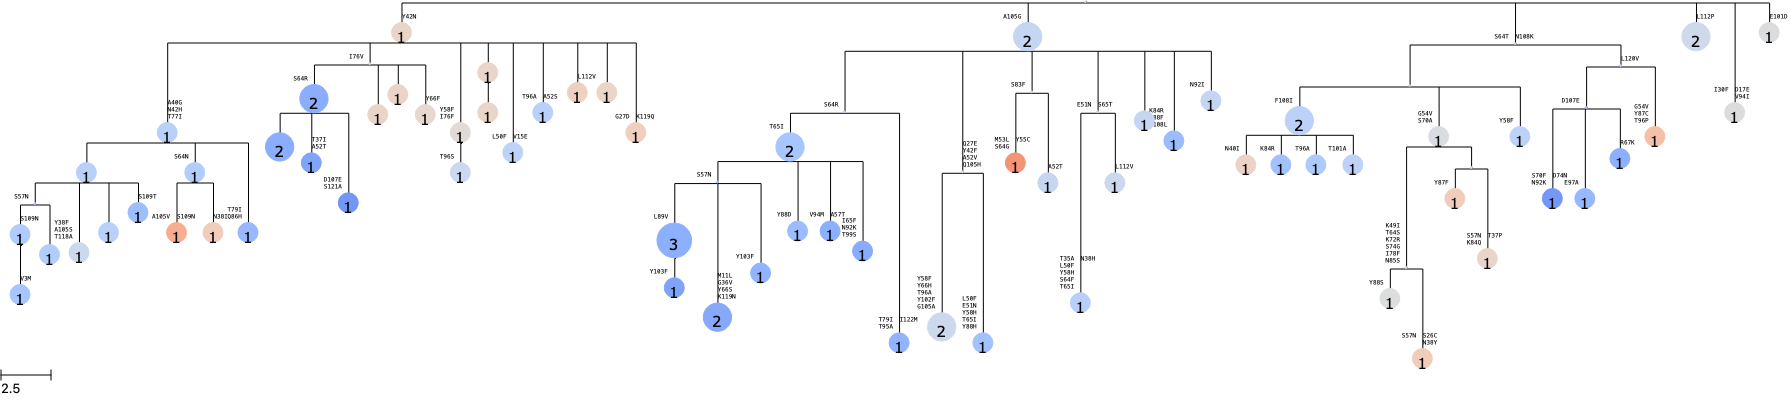

gc16HK


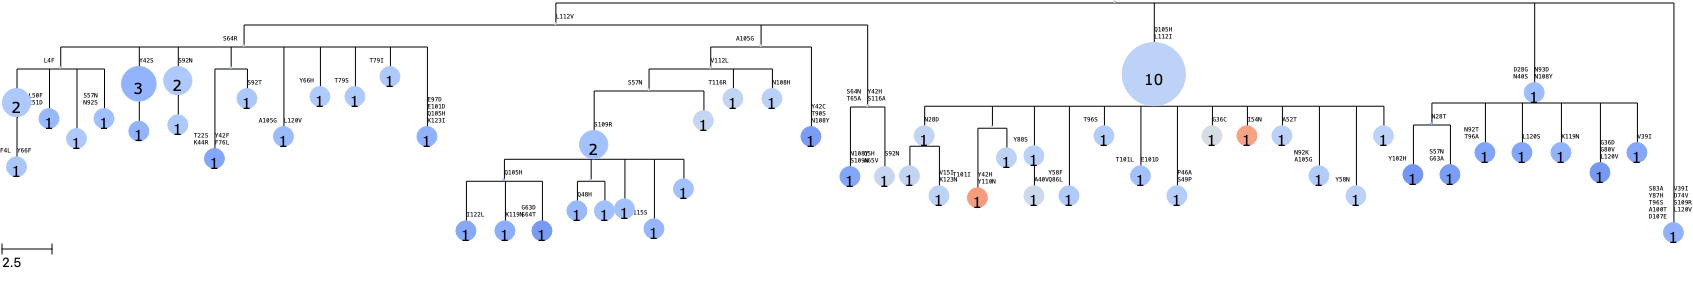

gc46HK


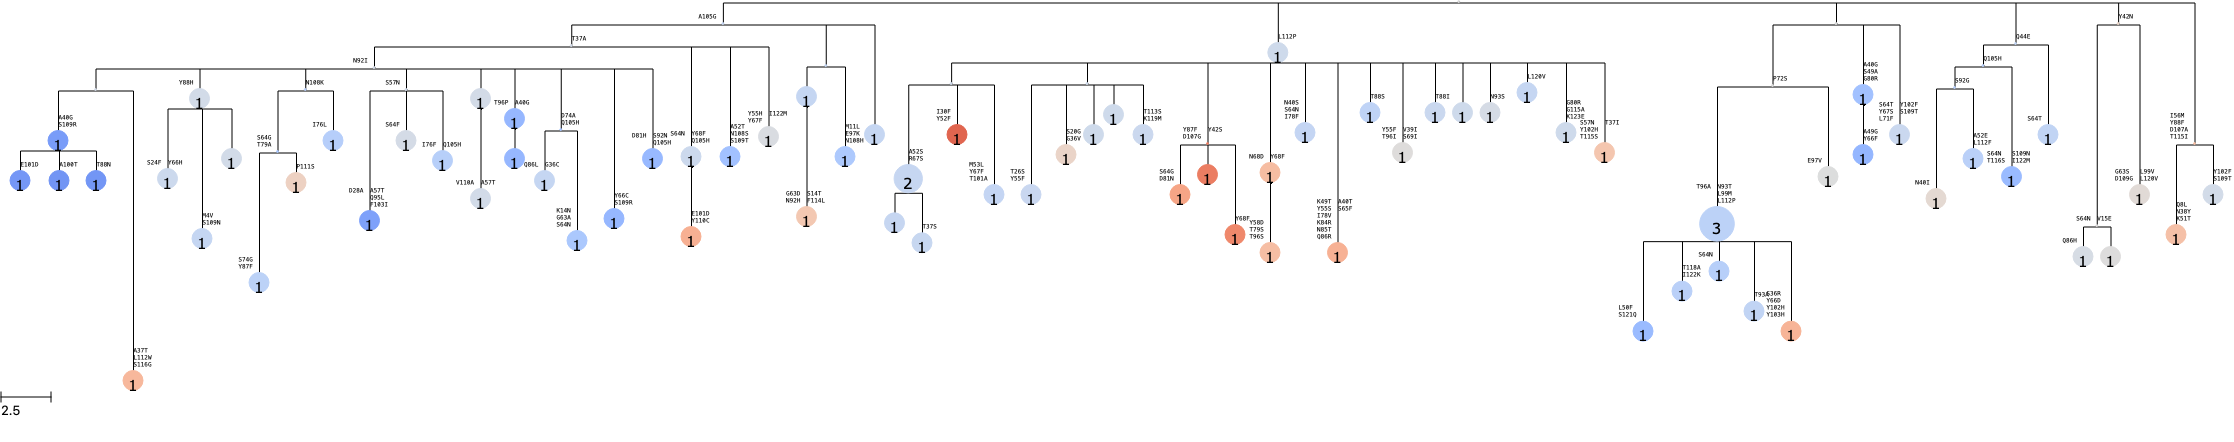

gc30HK


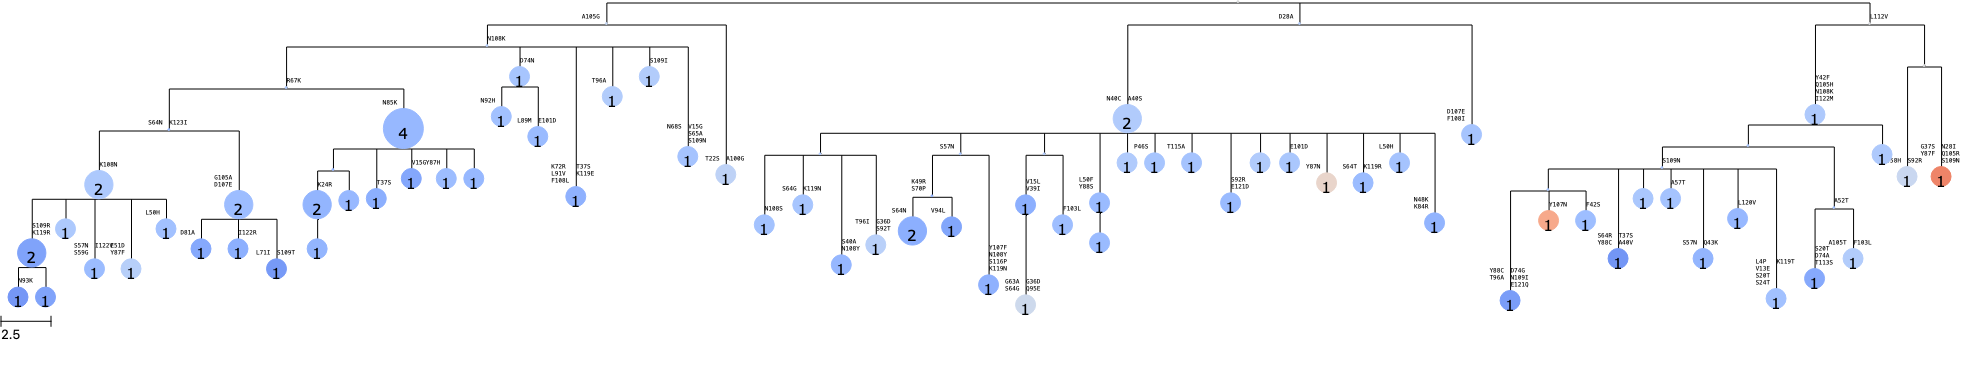

gc14HK


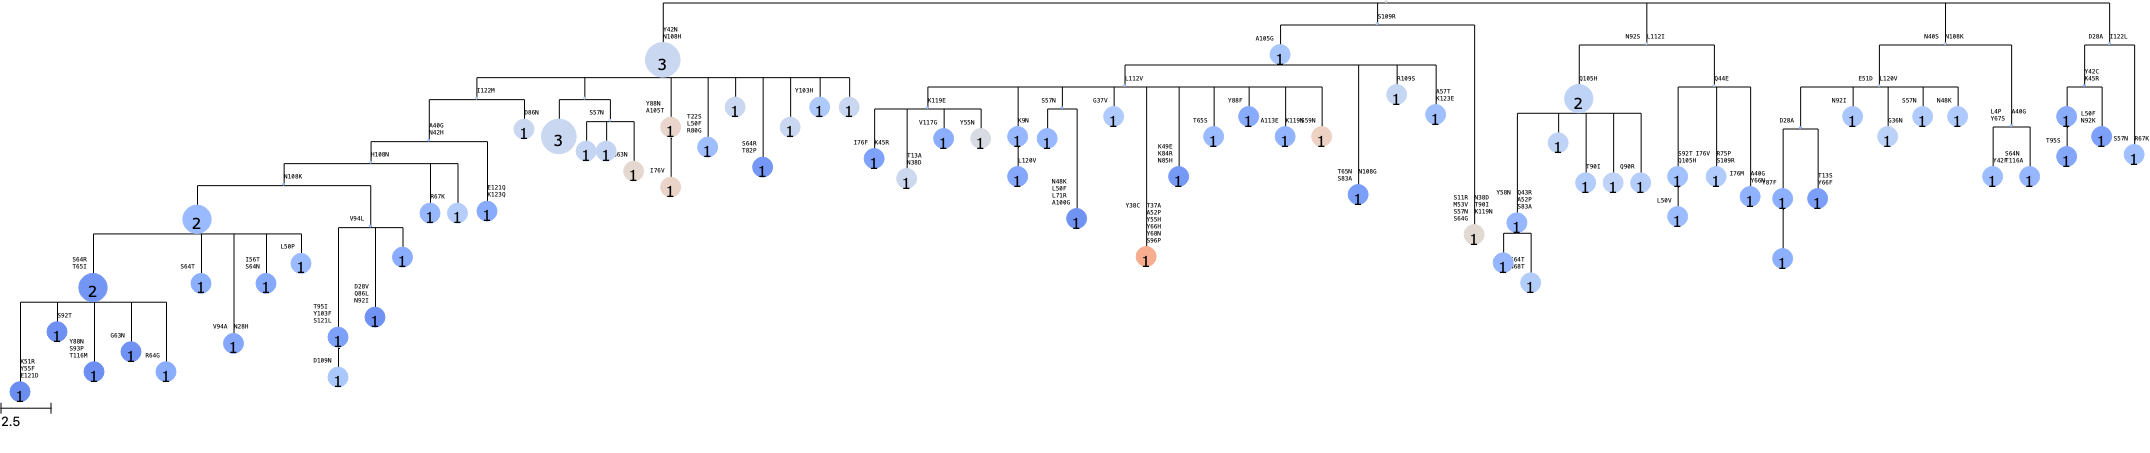

gc6HK


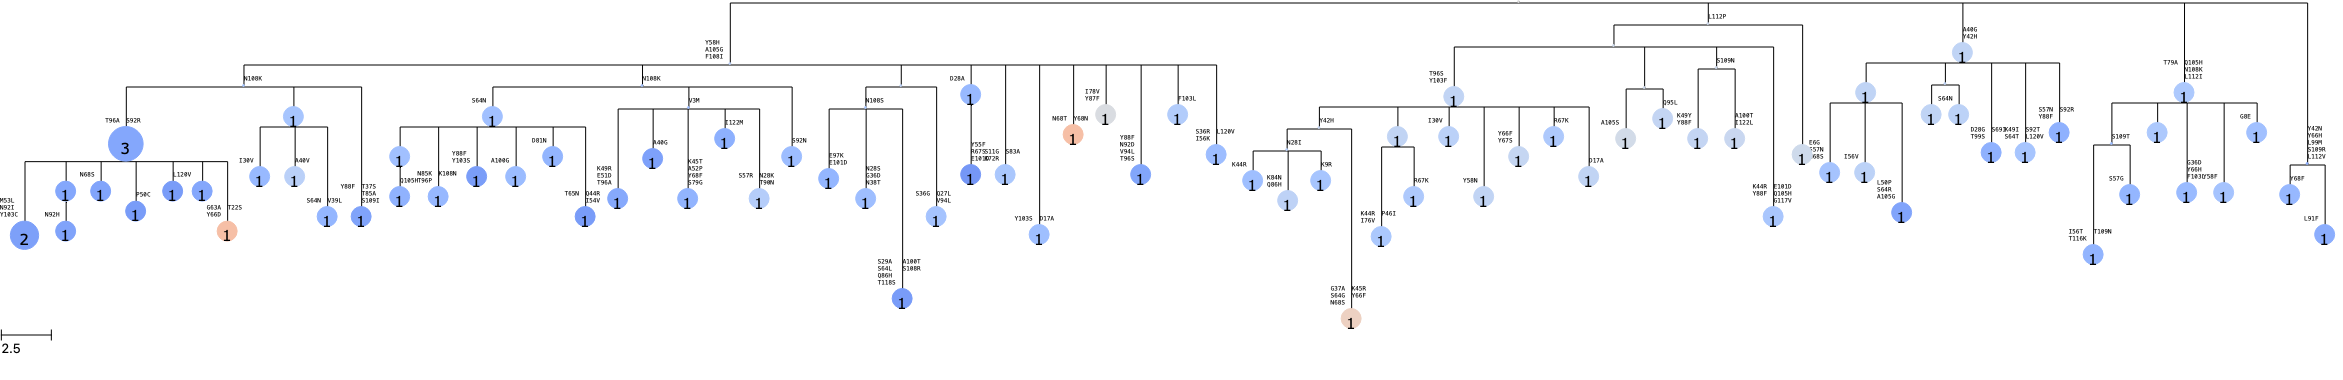

gc2HK


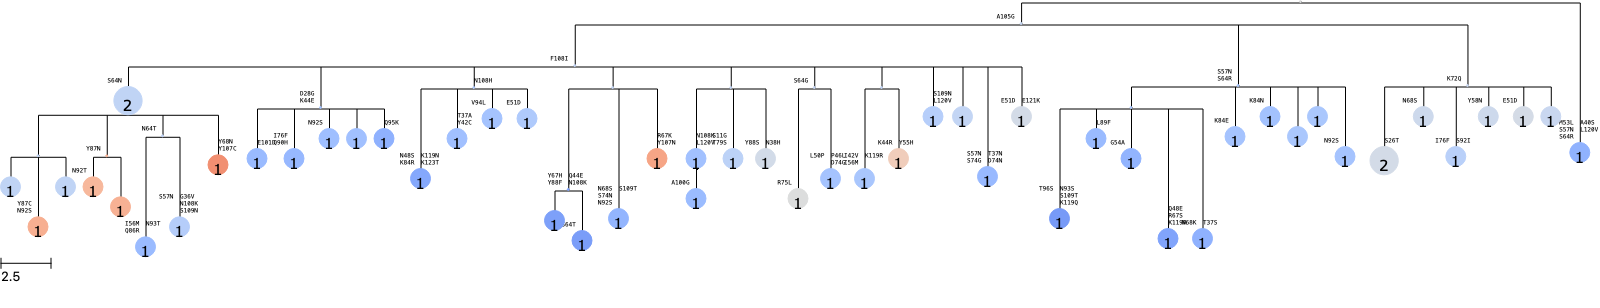

gc81HK


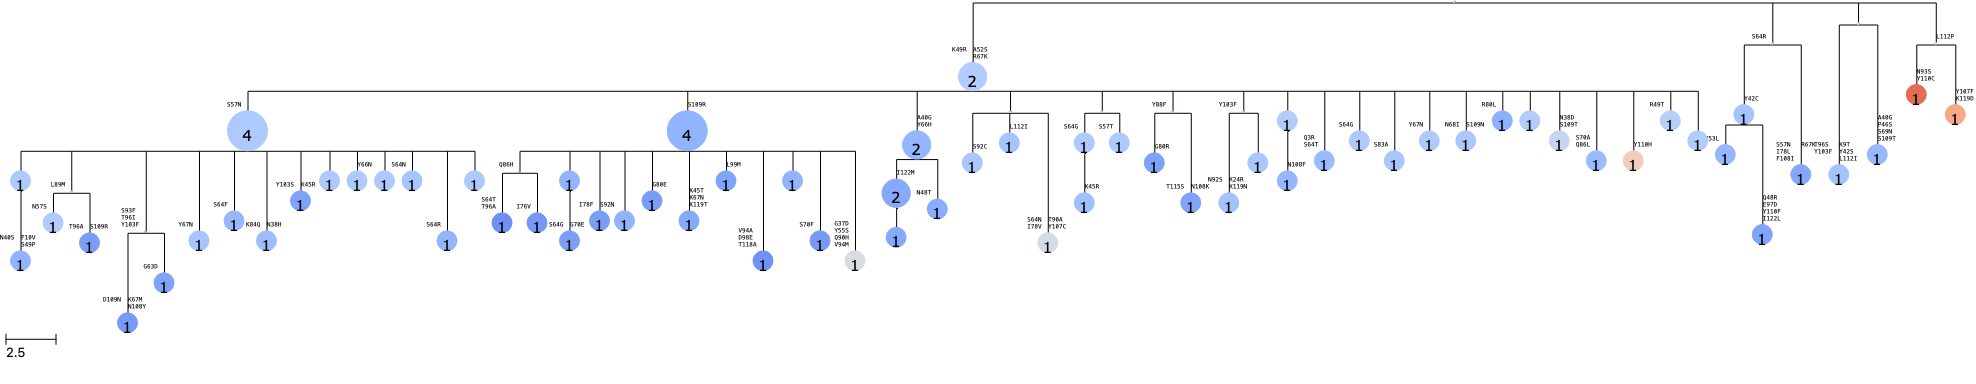

gc1HK


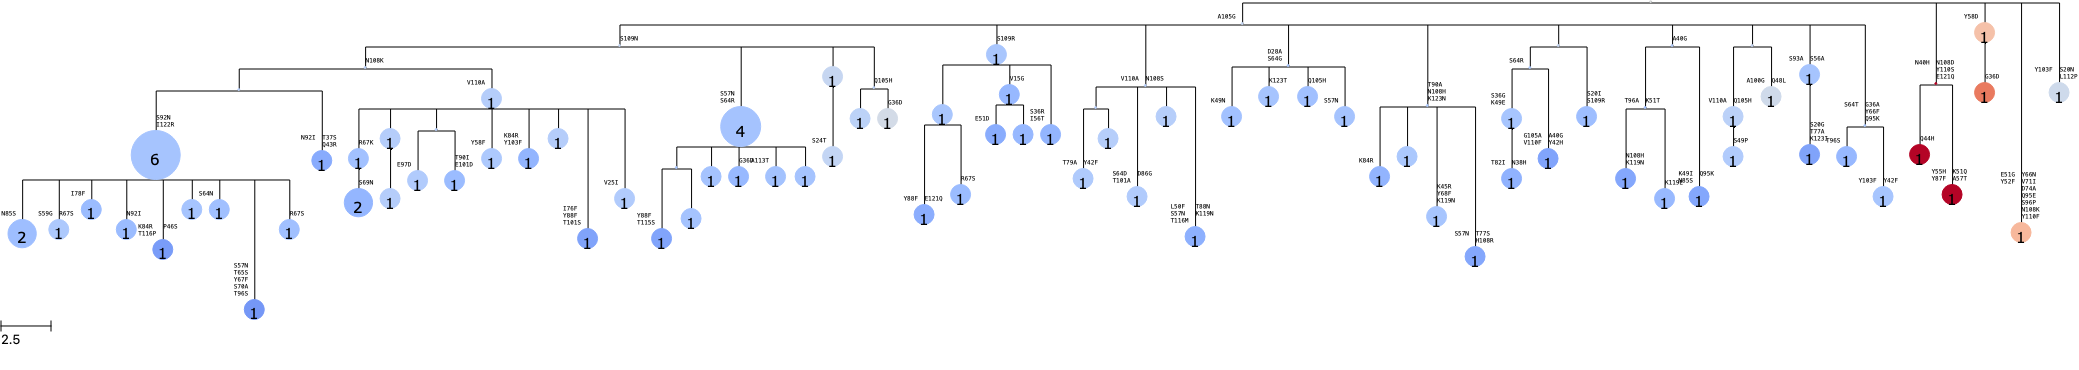

gc68HK


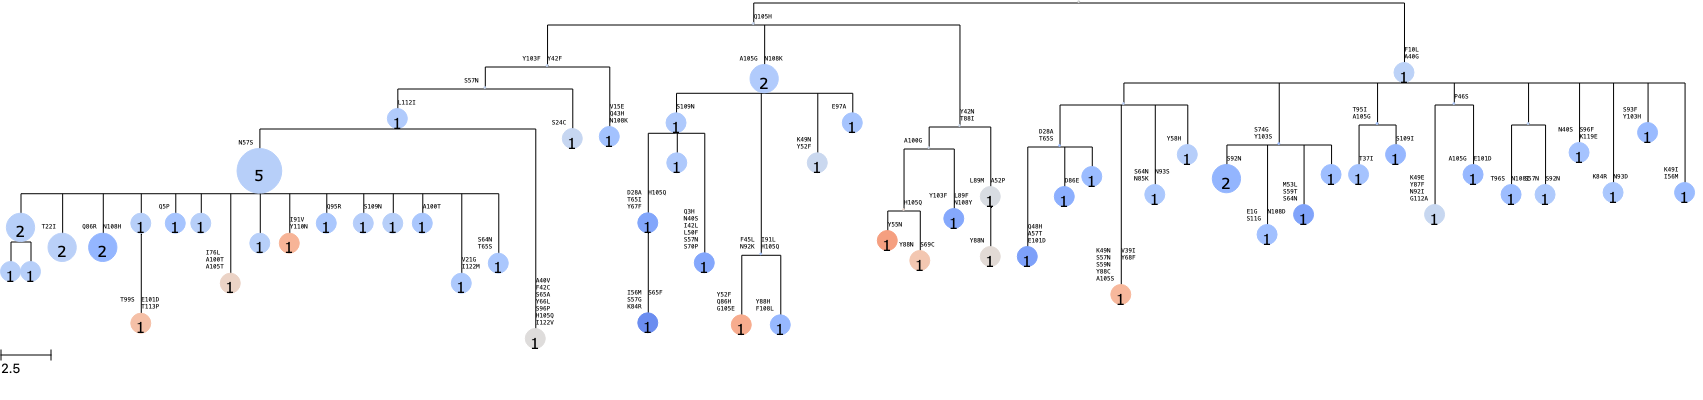

gc79HK


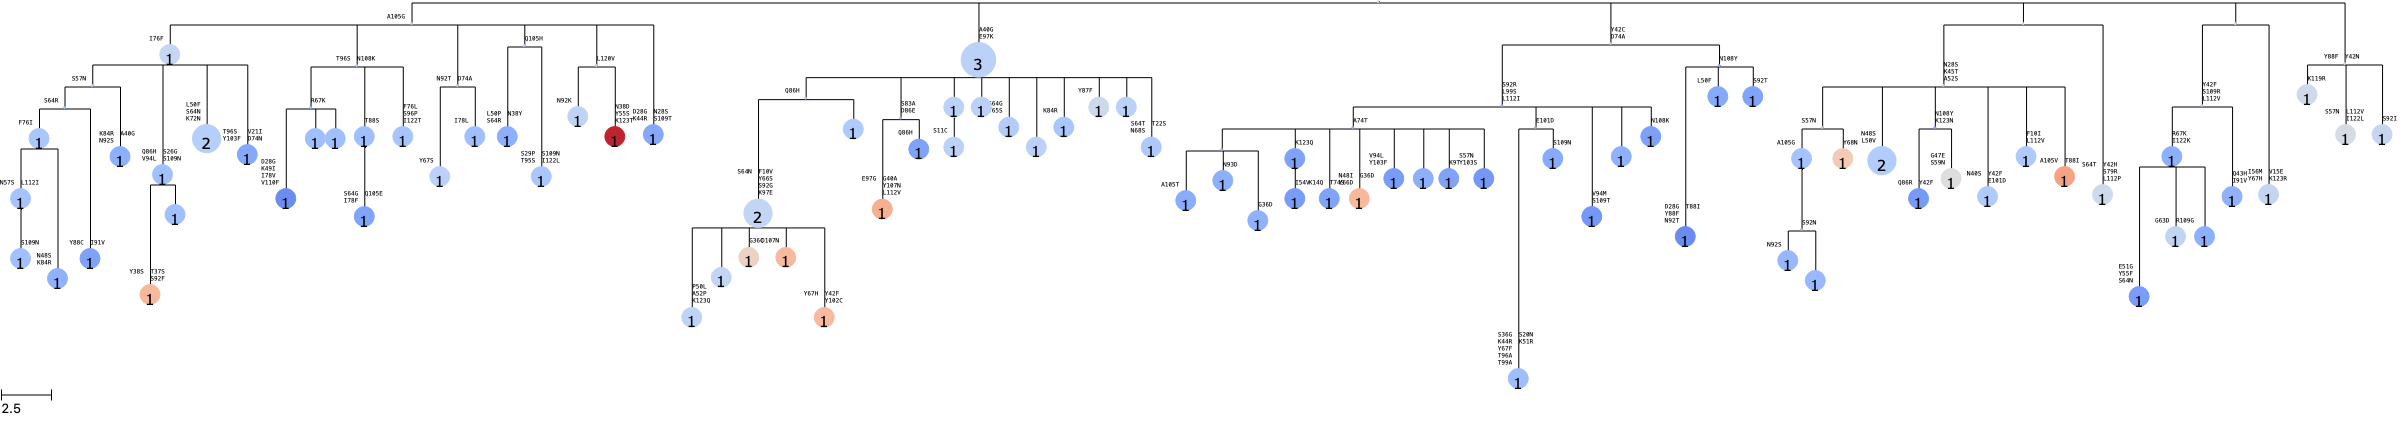

gc80HK


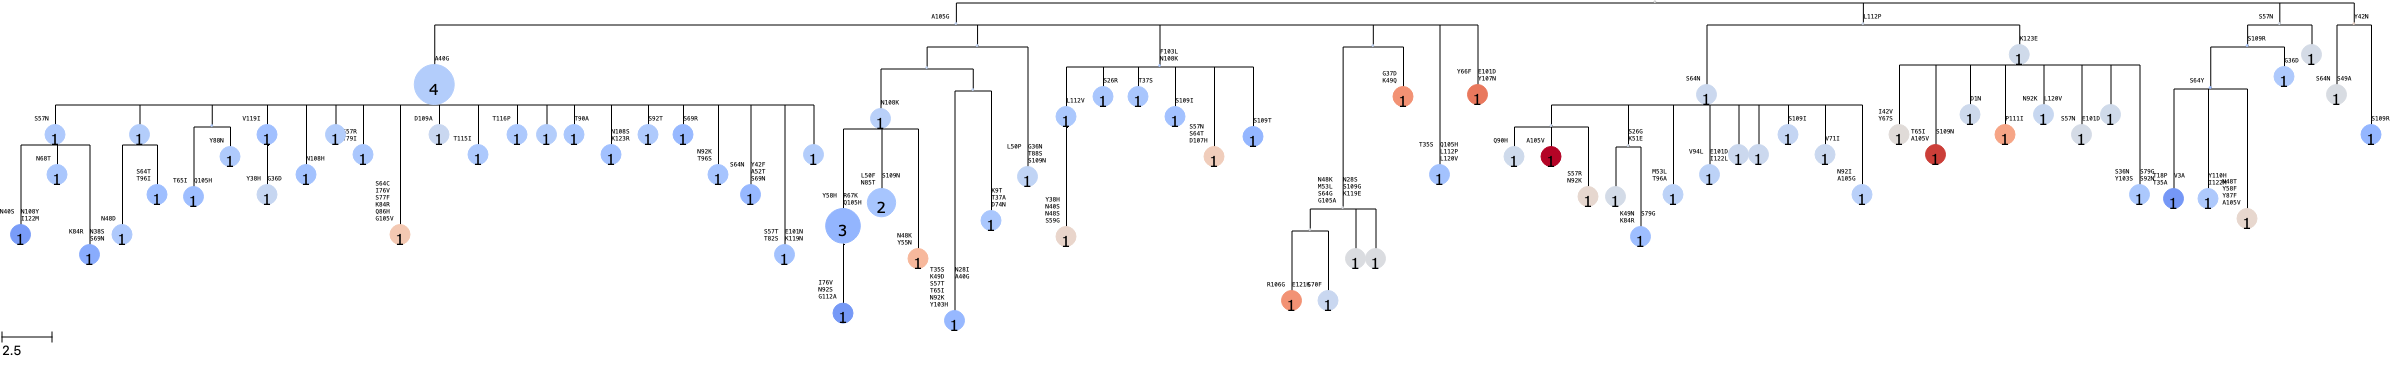

gc69HK


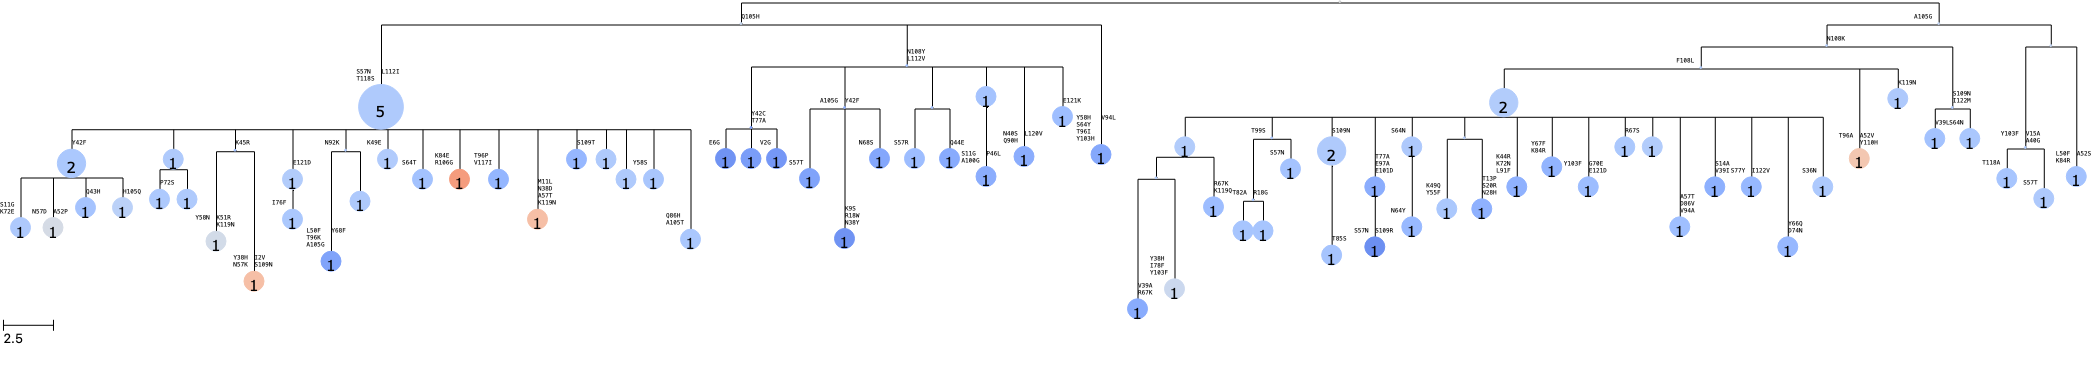

gc70HK


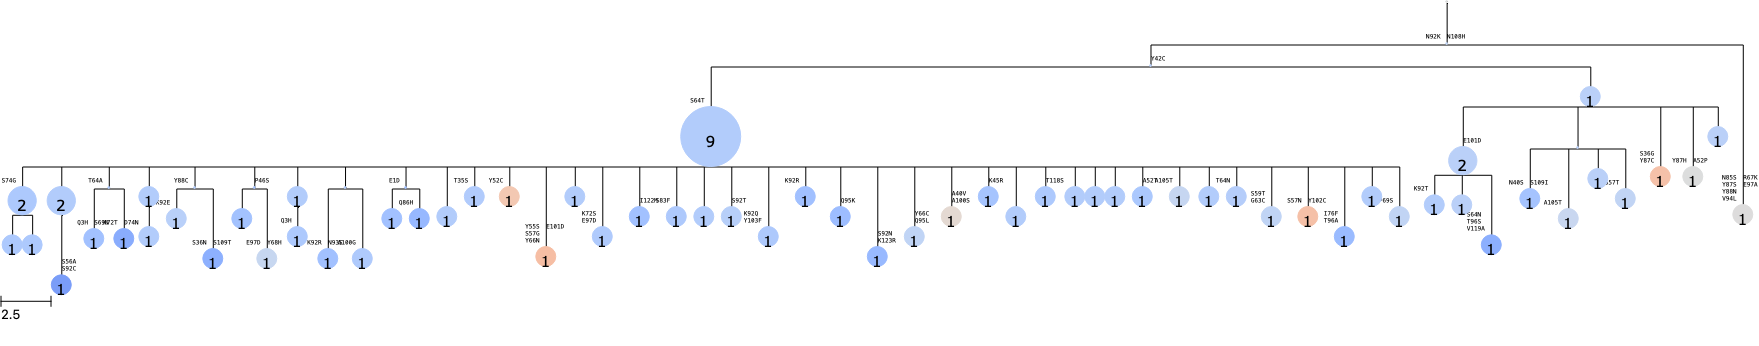

gc15HK


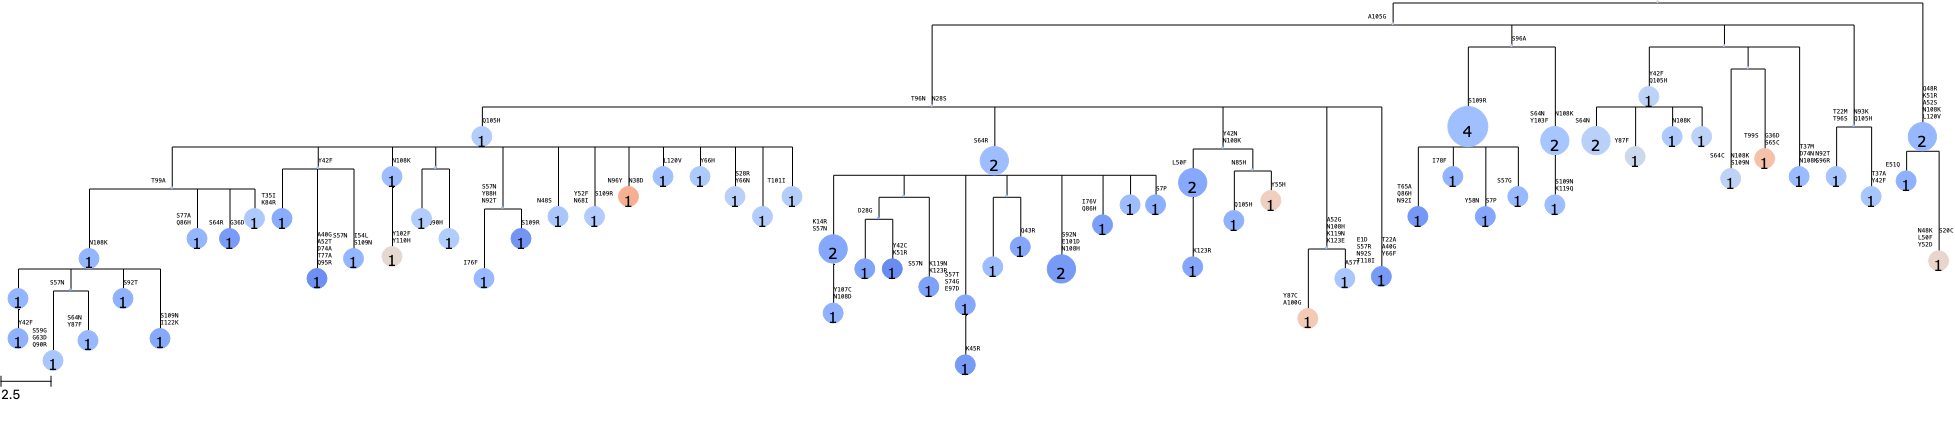

gc32HK


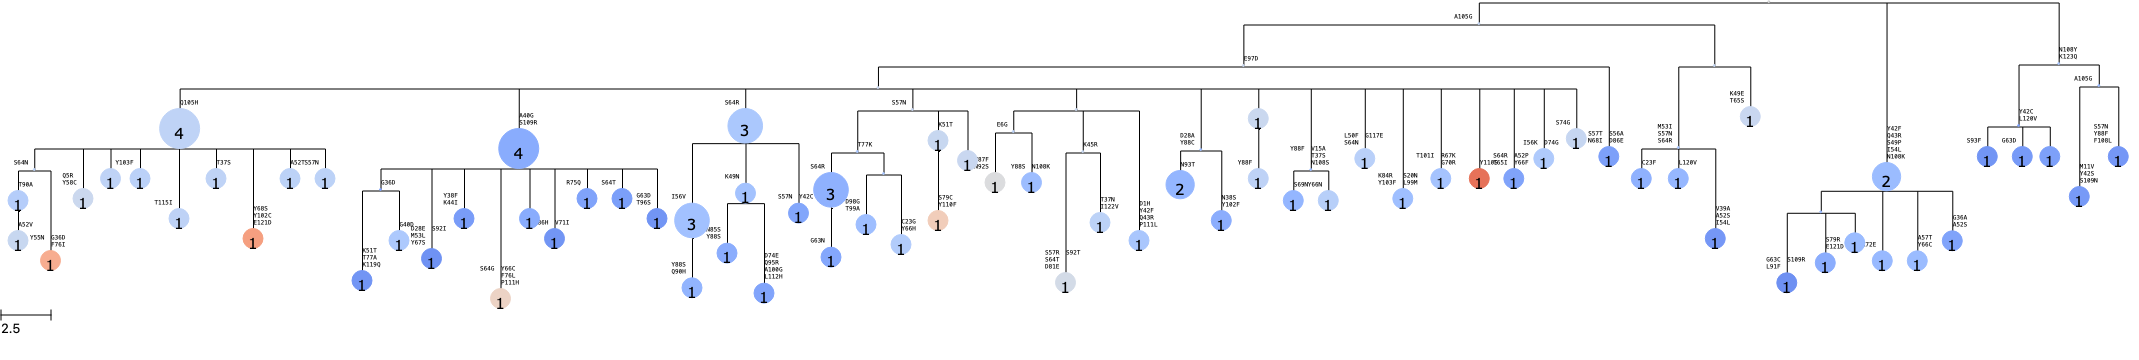

gc20HK-BC1


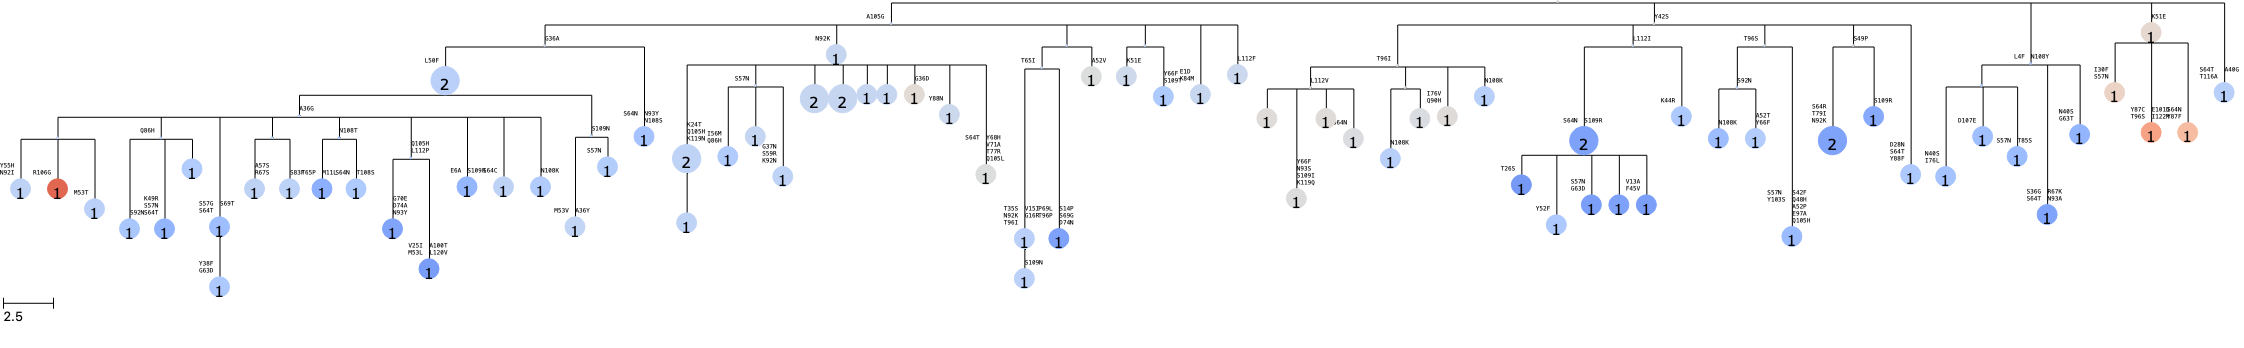

gc38HK-2


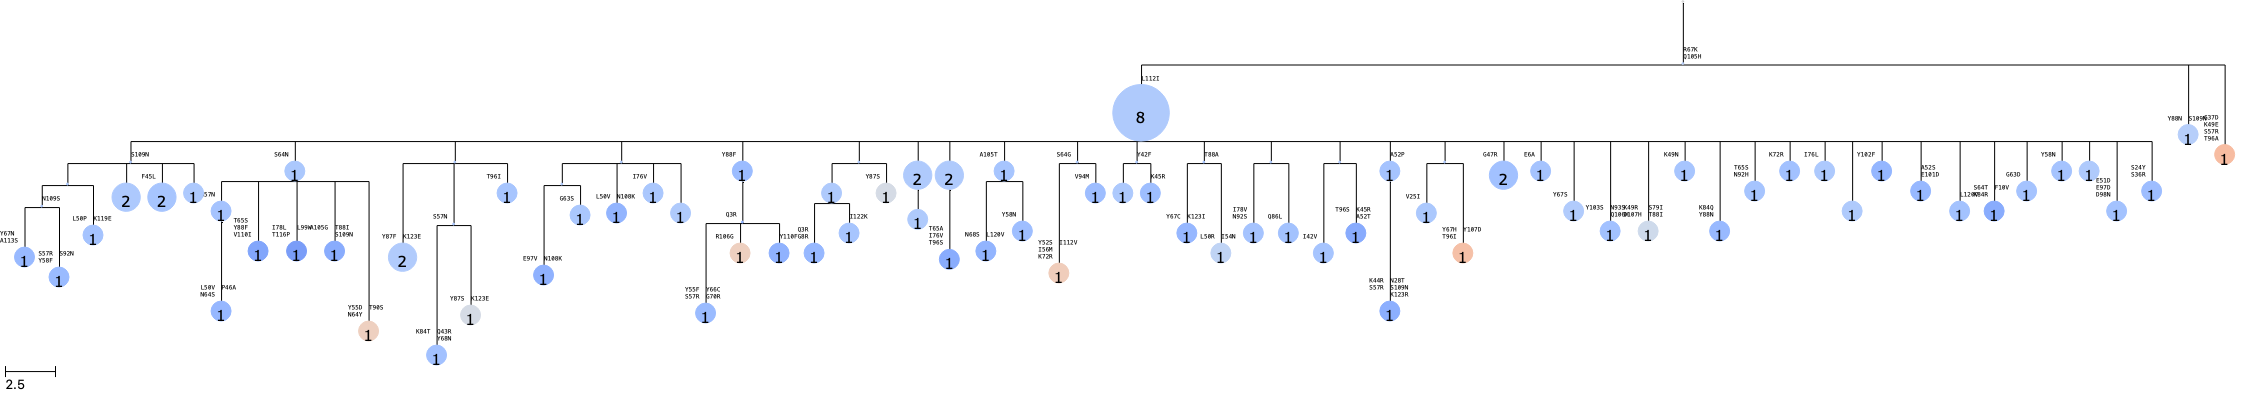

gc72HK-2


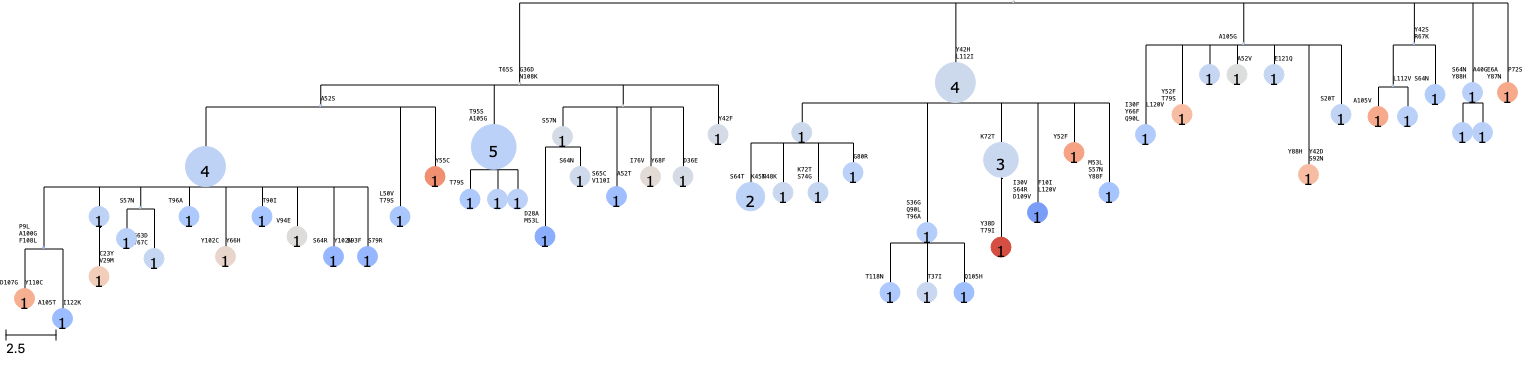

gc73HK-2


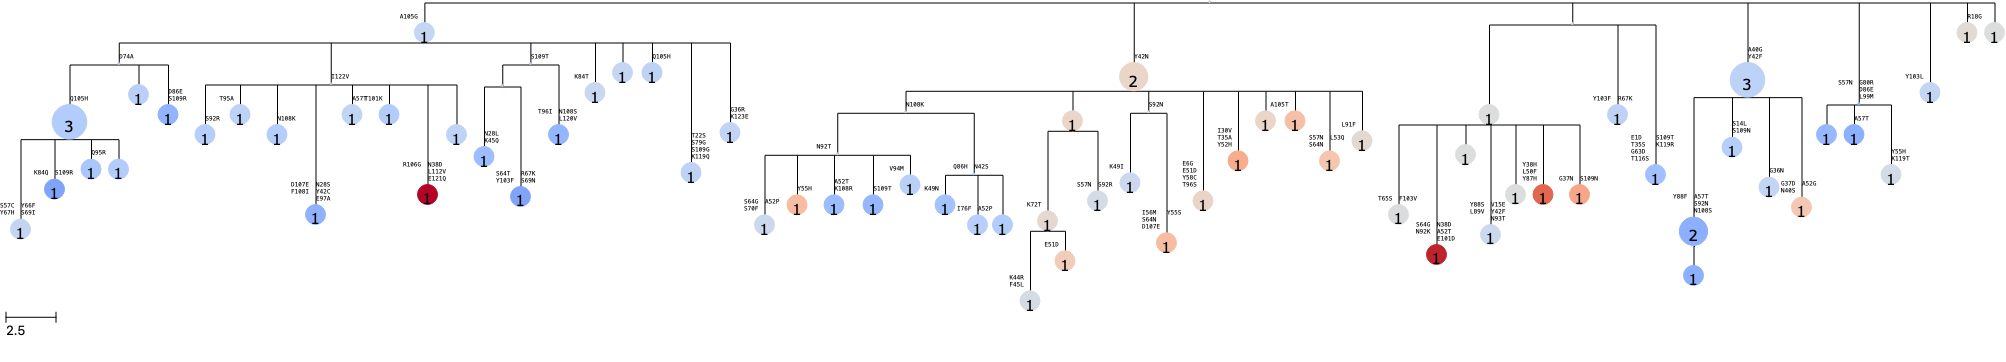

gc58HK-2


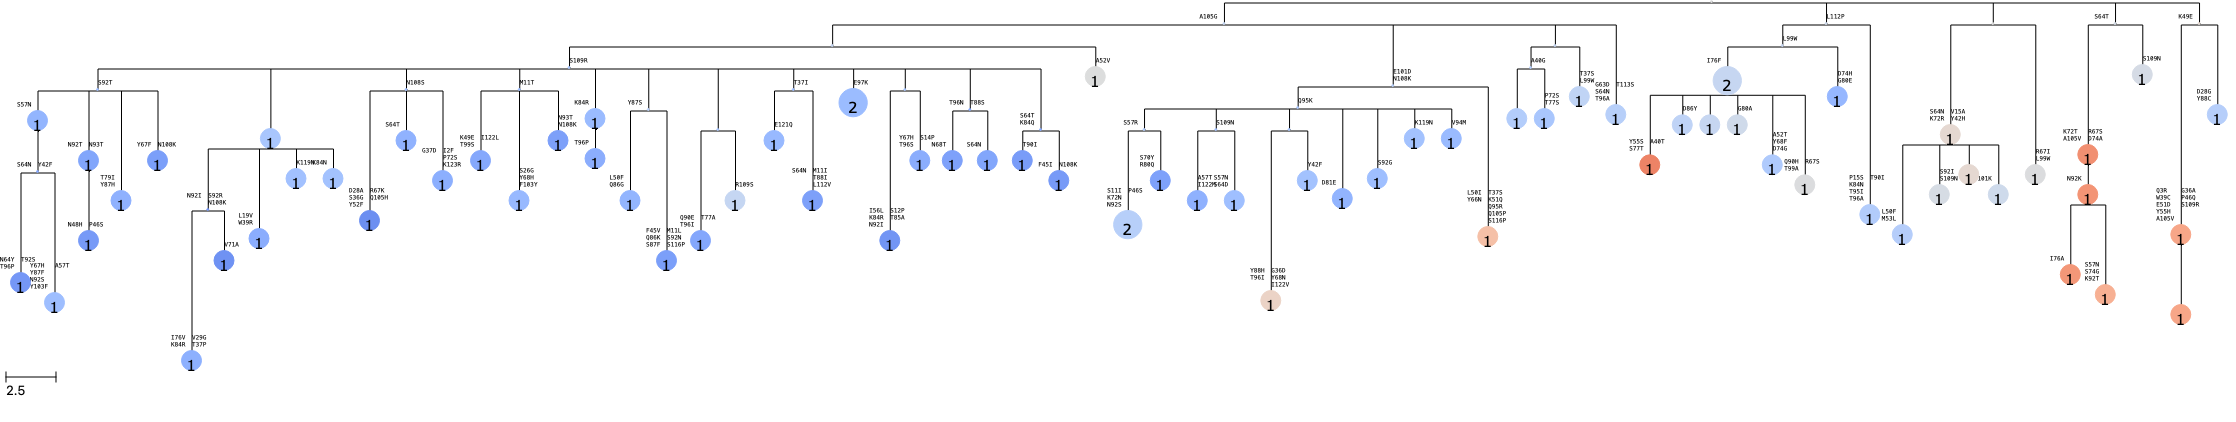

gc74HK-2


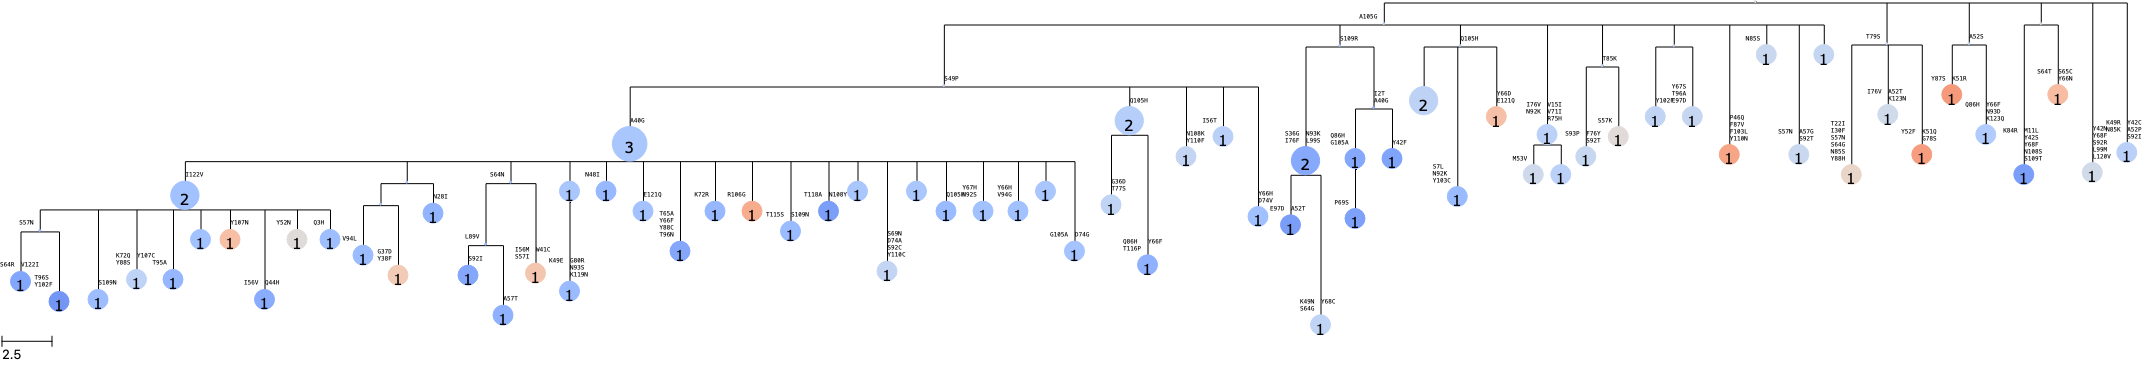

gc48HK-2


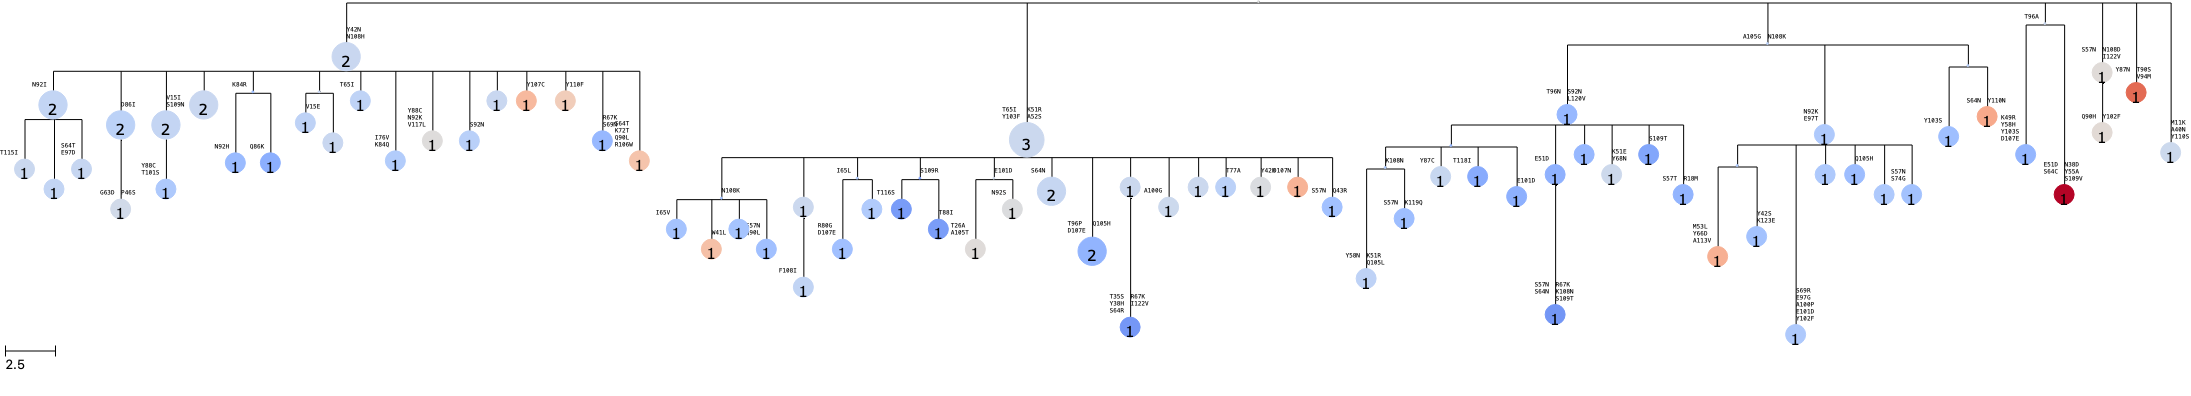

gc47HK-2


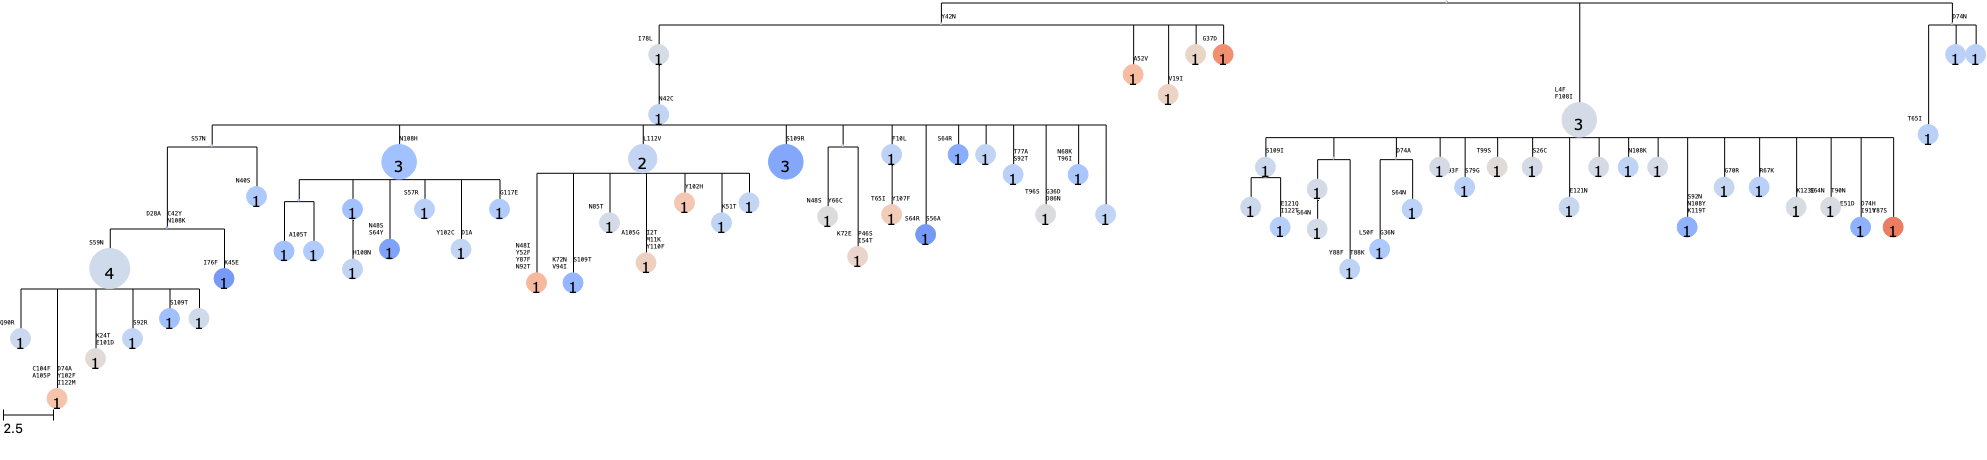

gc78HK-2


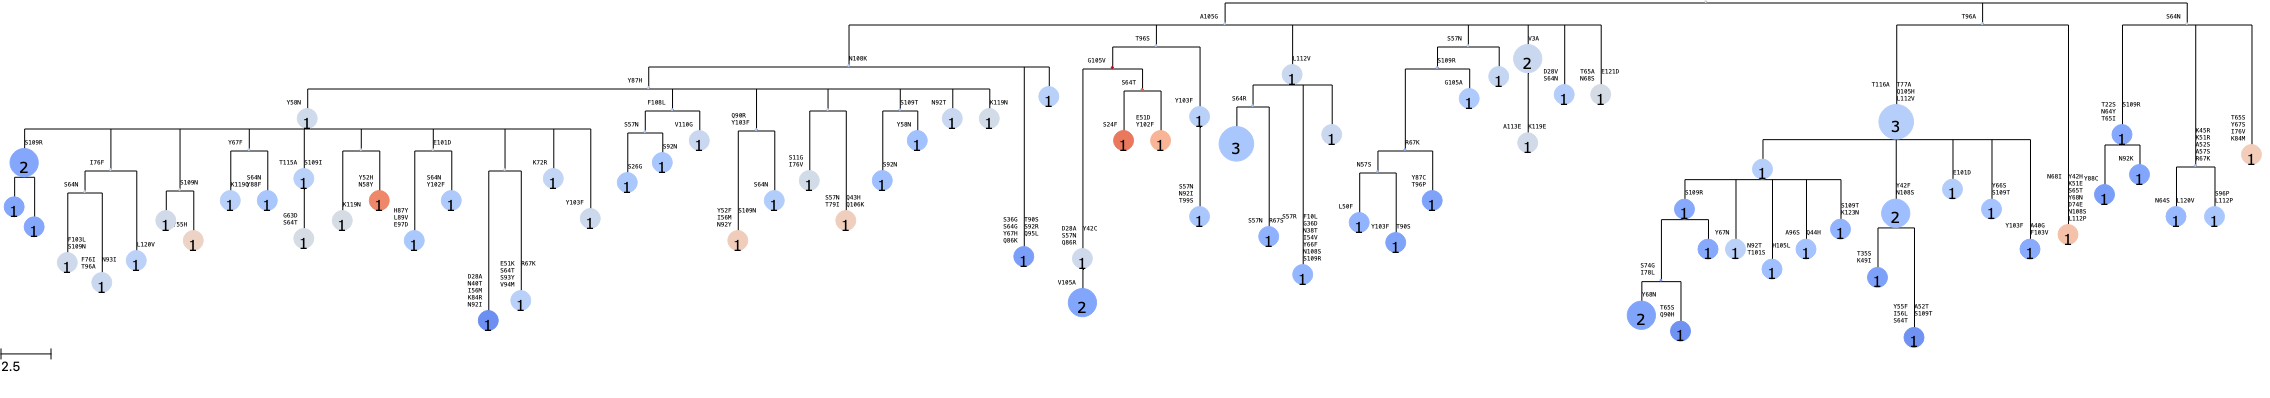

gc55HK-2


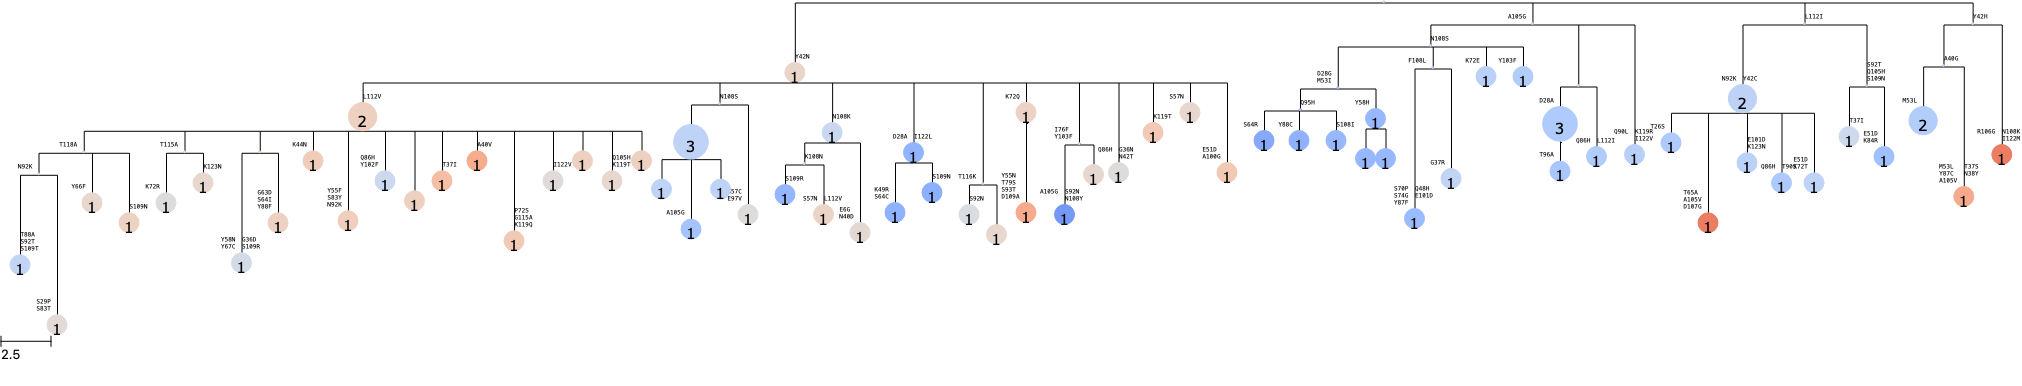

gc82HK-2


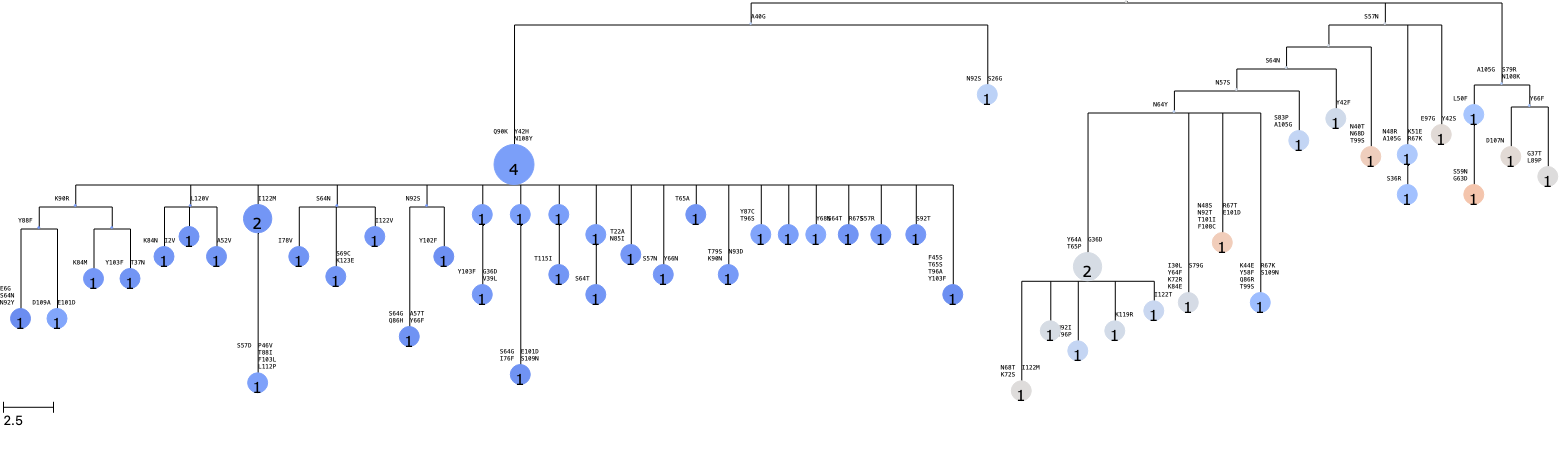

gc83HK-2


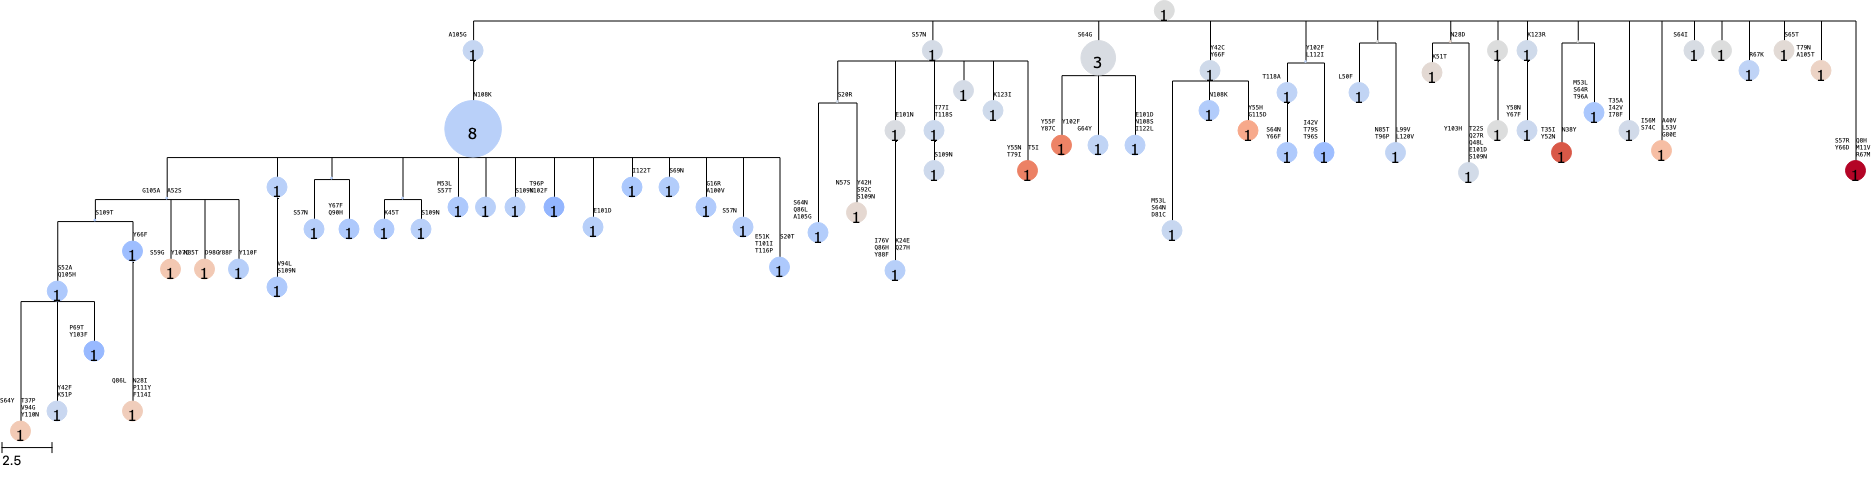

In [94]:
cmap = cm.get_cmap("coolwarm_r")
norm = Normalize(vmin=vmin, vmax=vmax)

for gc, tree in trees.items():
    print(gc)
    colormap = {node.name: to_hex(cmap(norm(node.delta_bind)))
                for node in tree.tree.traverse()}
    for file in (f"output/plots/colormapped_gctrees/{gc}.delta_bind.svg", "%%inline"):
        rendering = tree.render(file, scale=20,
                            colormap=colormap,
                            frame=igh_frame, frame2=igk_frame, chain_split=igk_idx,
                            position_map=igh_pos_map.site, position_map2=igk_pos_map.site)
    display(rendering)

## Color map local branching index (LBI)

gc31HK


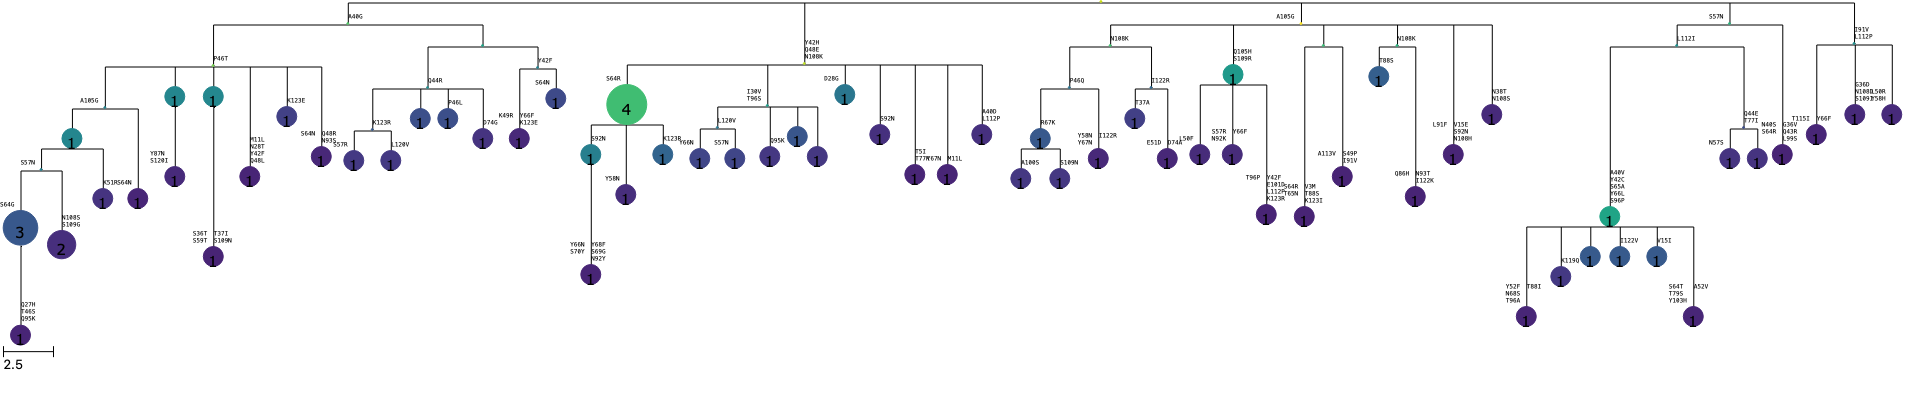

gc50HK


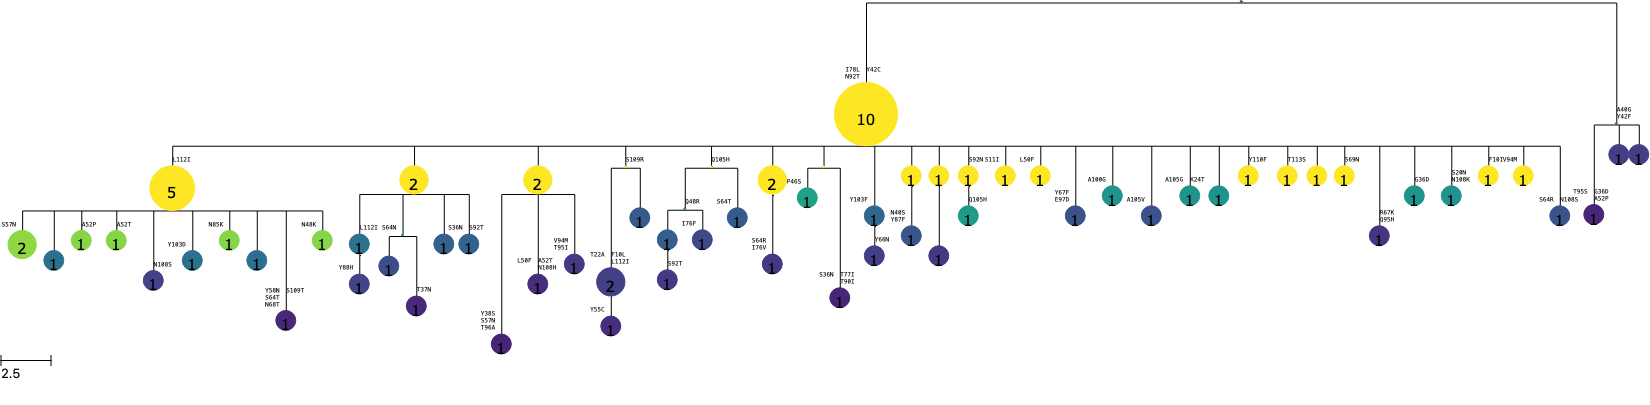

gc59HK


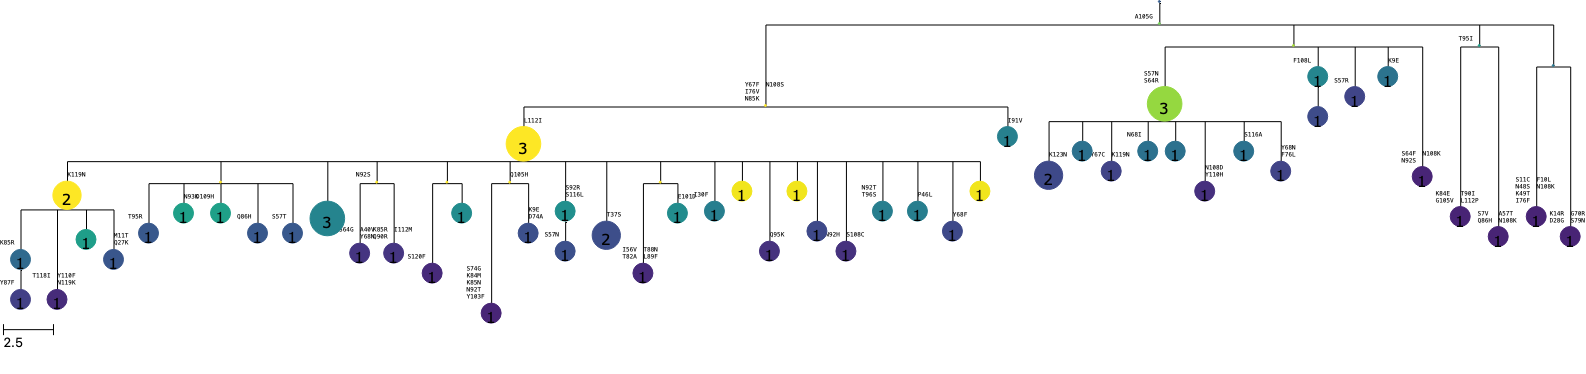

gc17HK


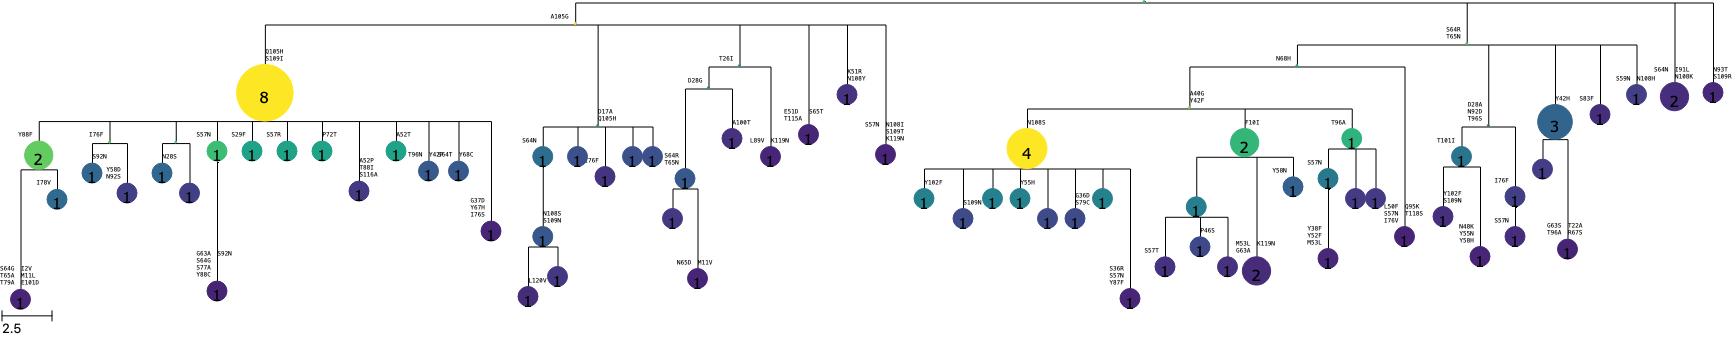

gc56HK


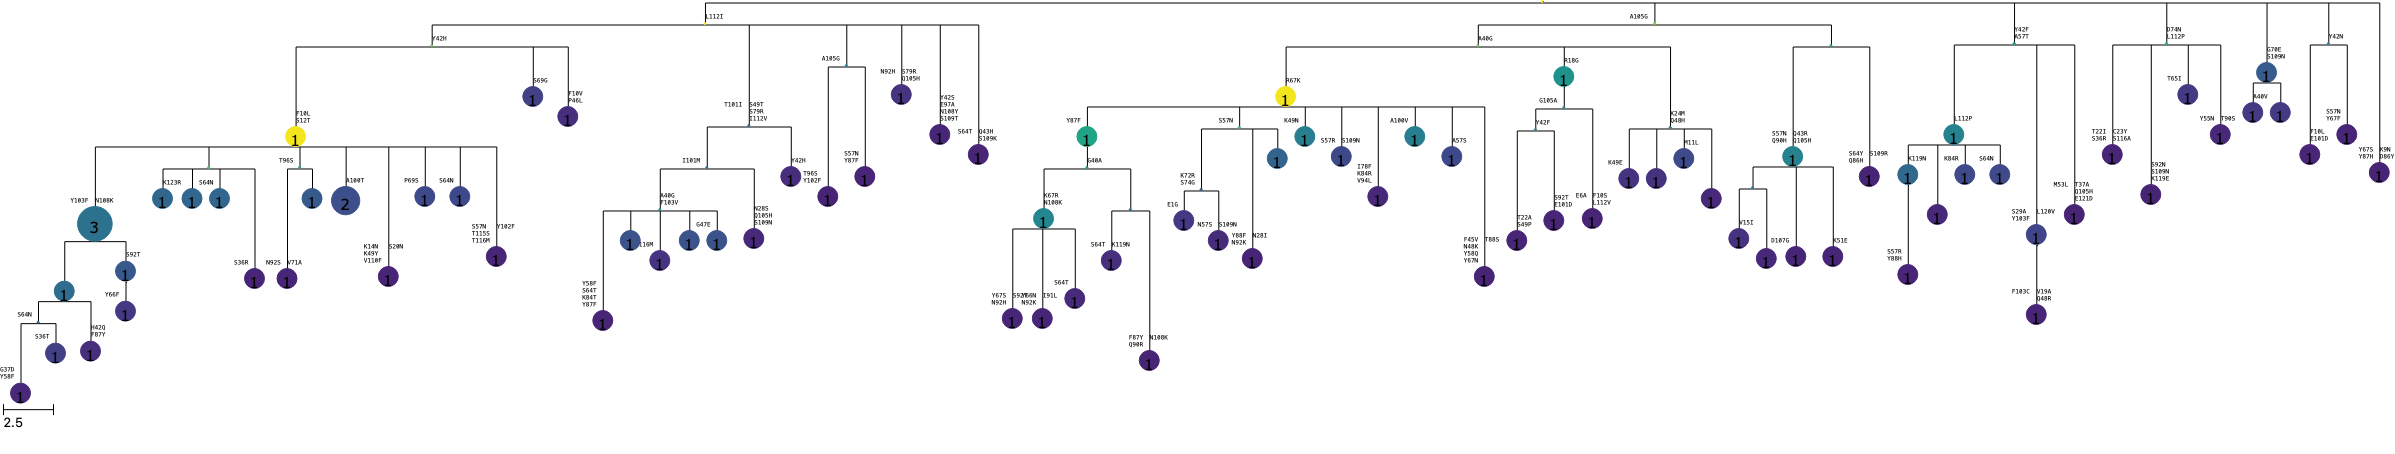

gc39HK


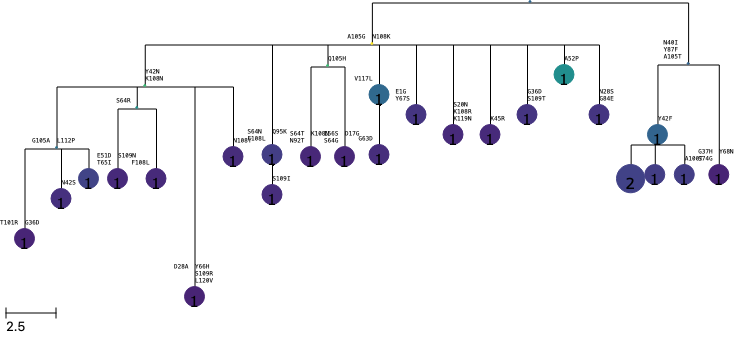

gc77HK


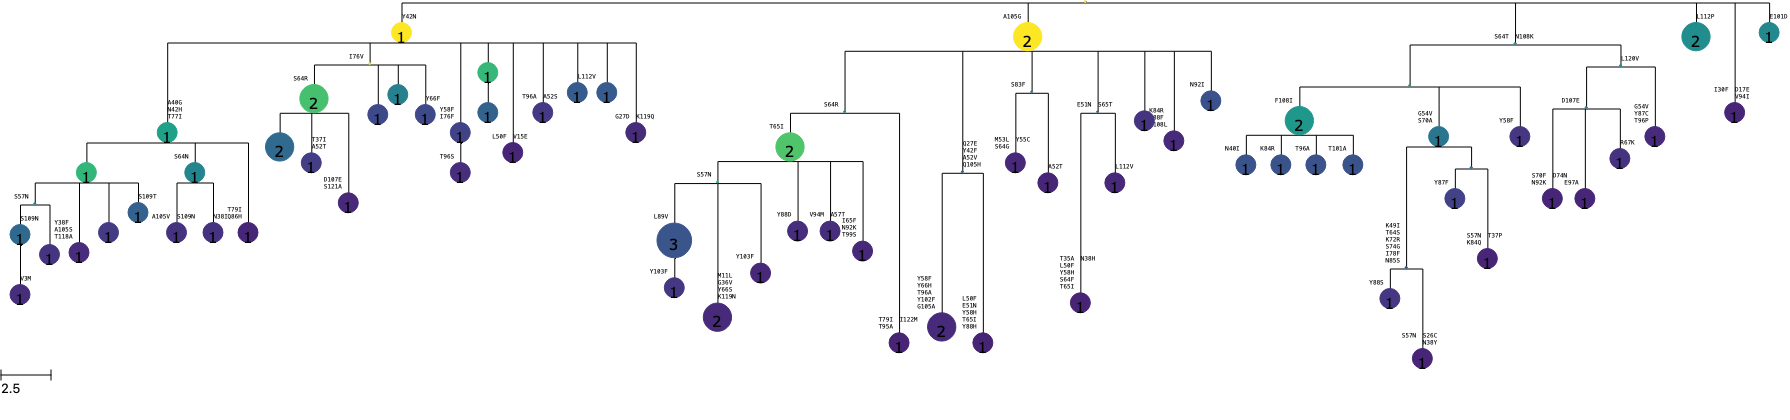

gc16HK


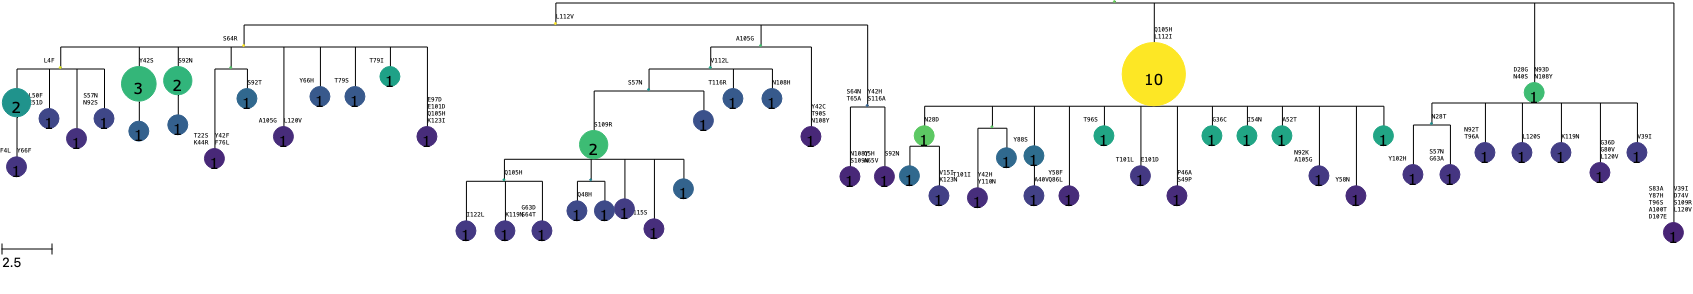

gc46HK


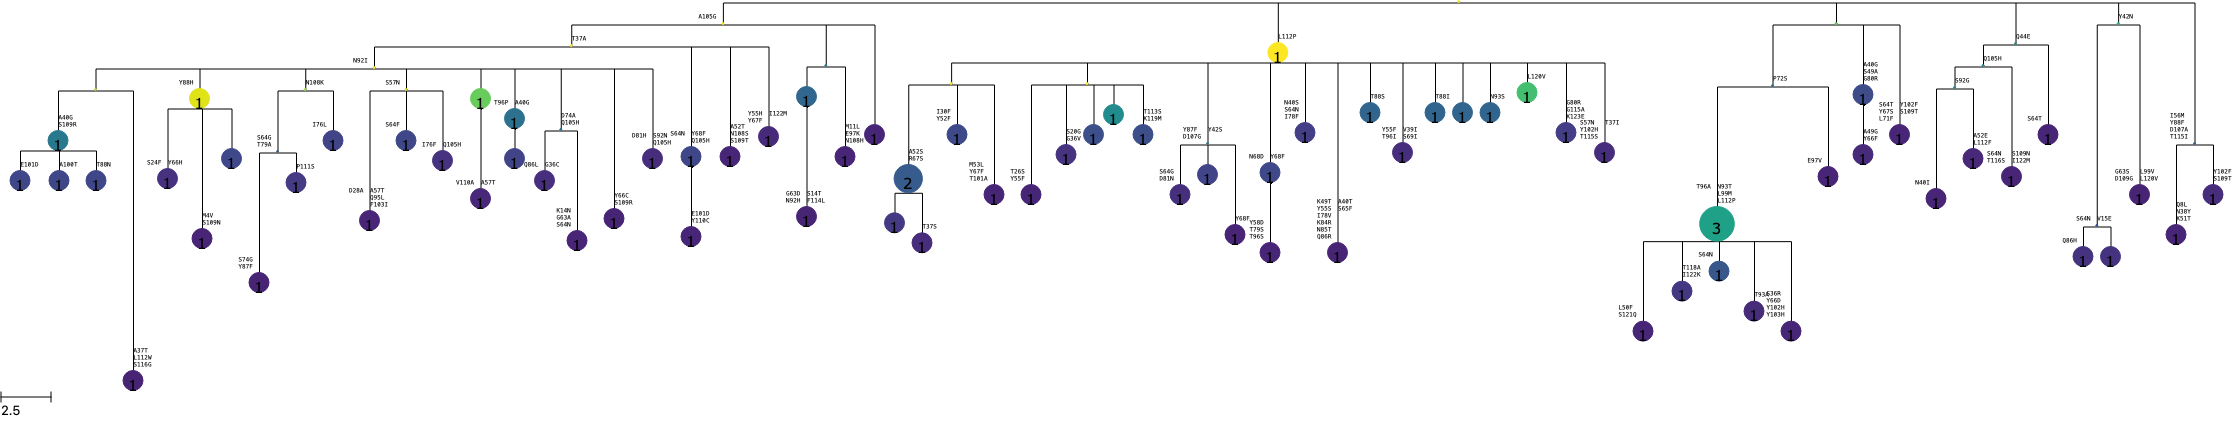

gc30HK


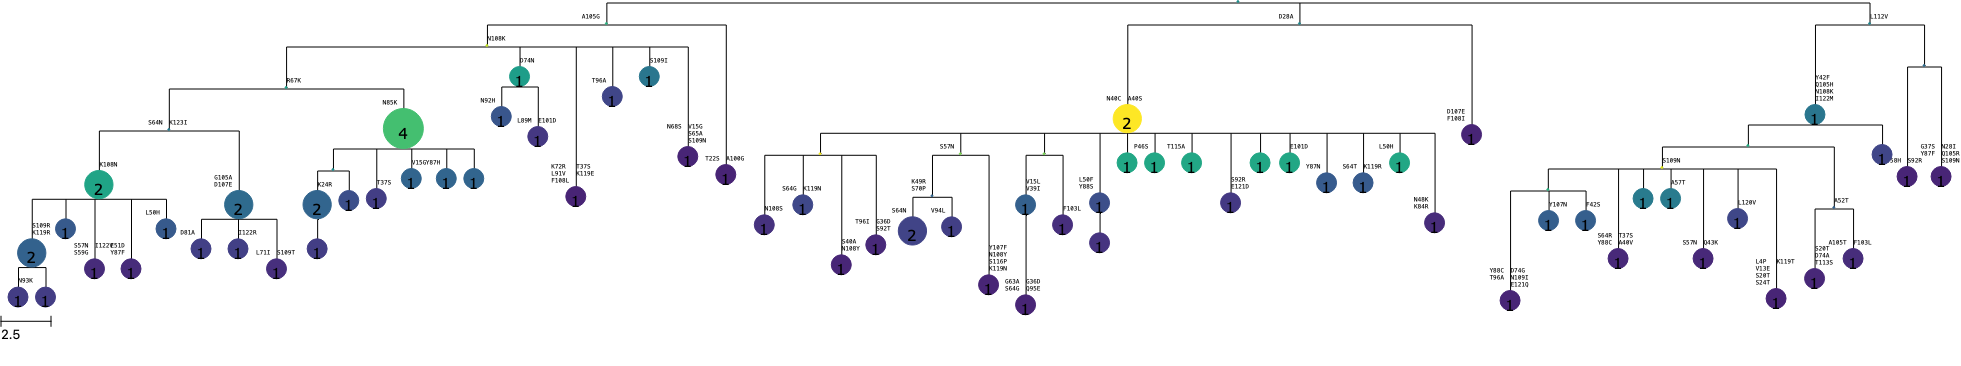

gc14HK


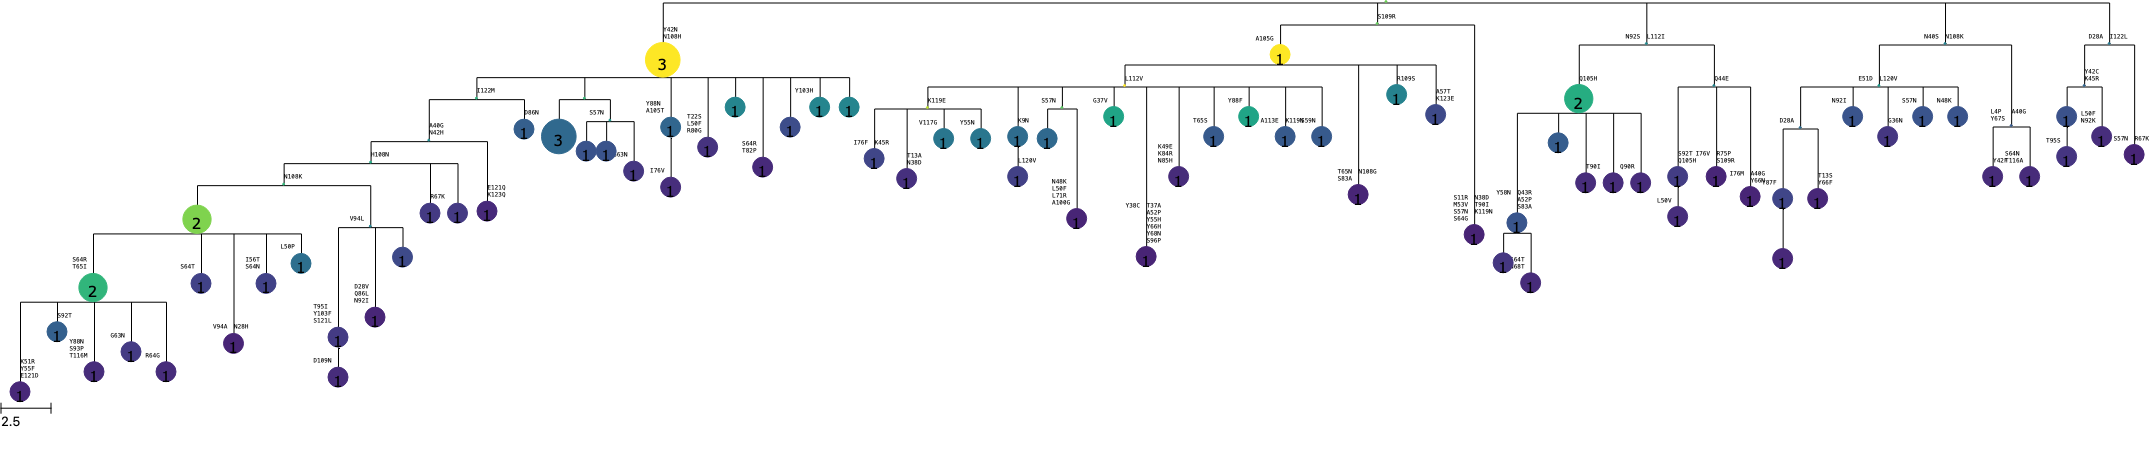

gc6HK


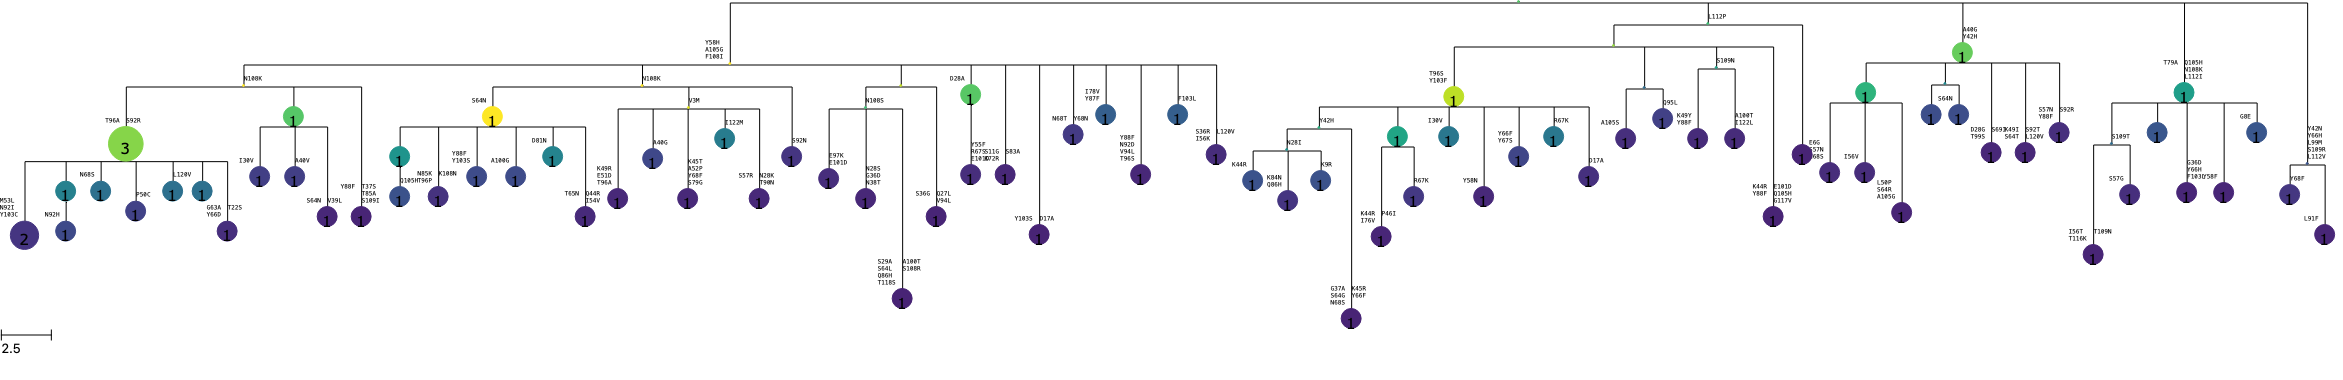

gc2HK


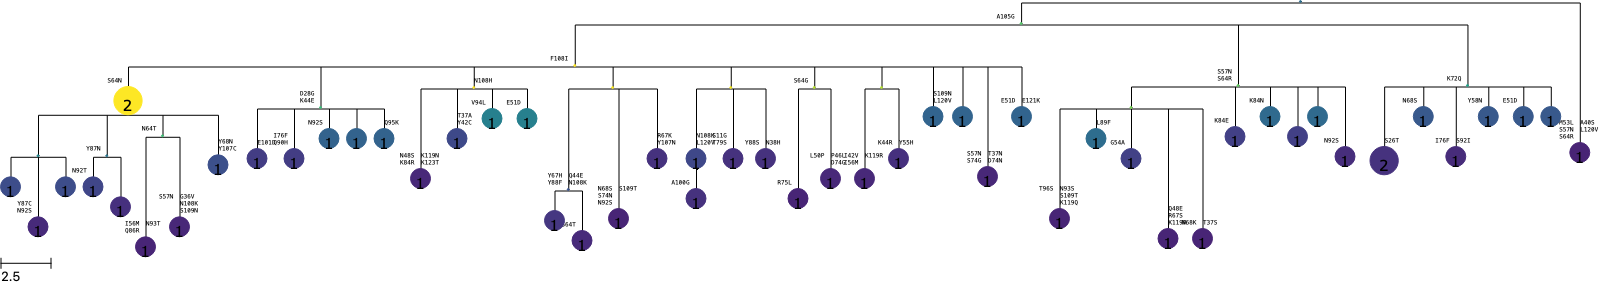

gc81HK


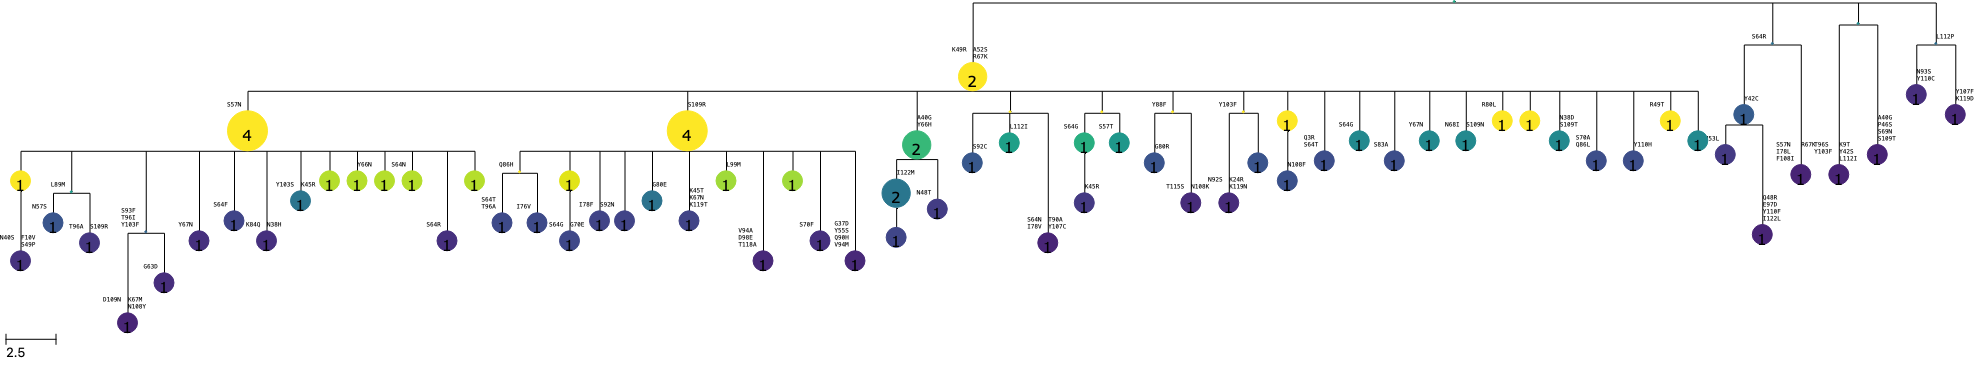

gc1HK


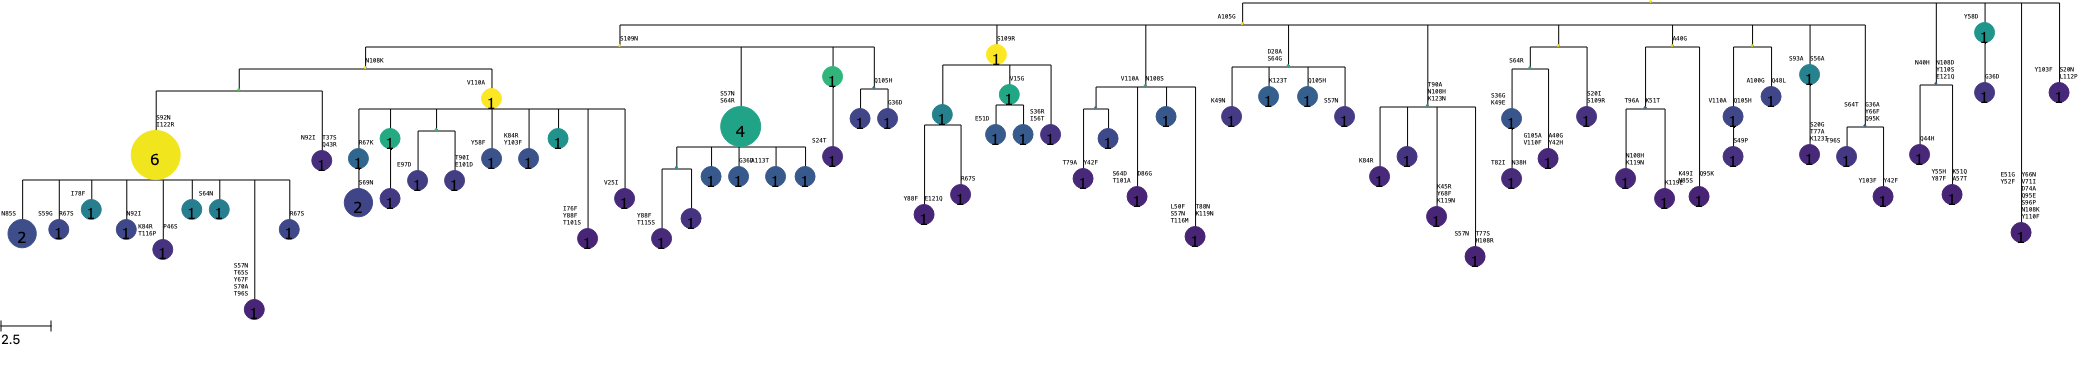

gc68HK


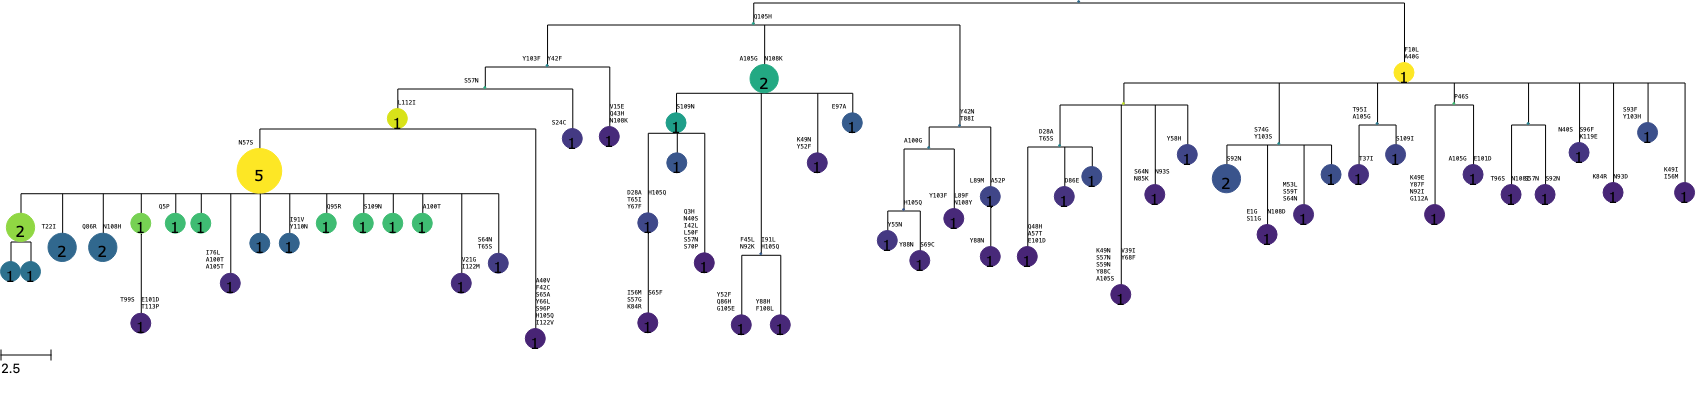

gc79HK


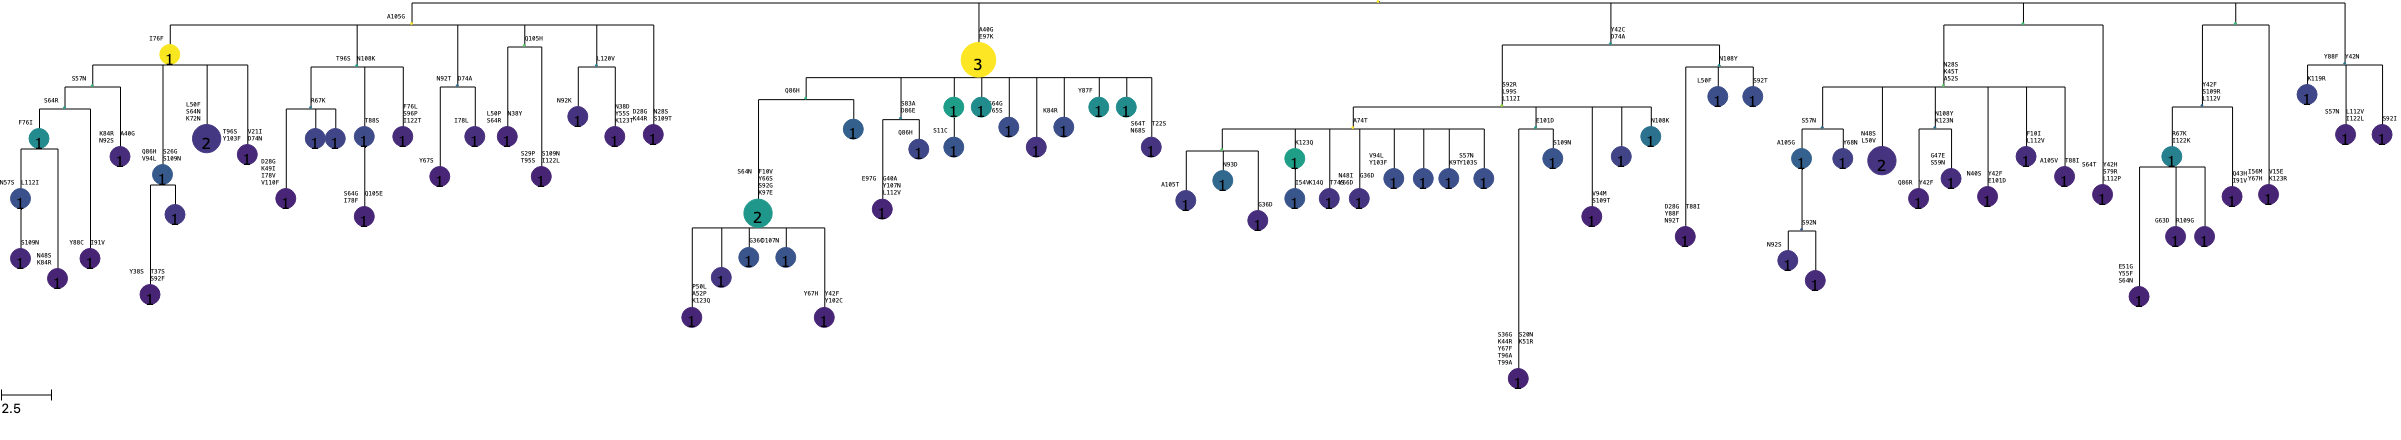

gc80HK


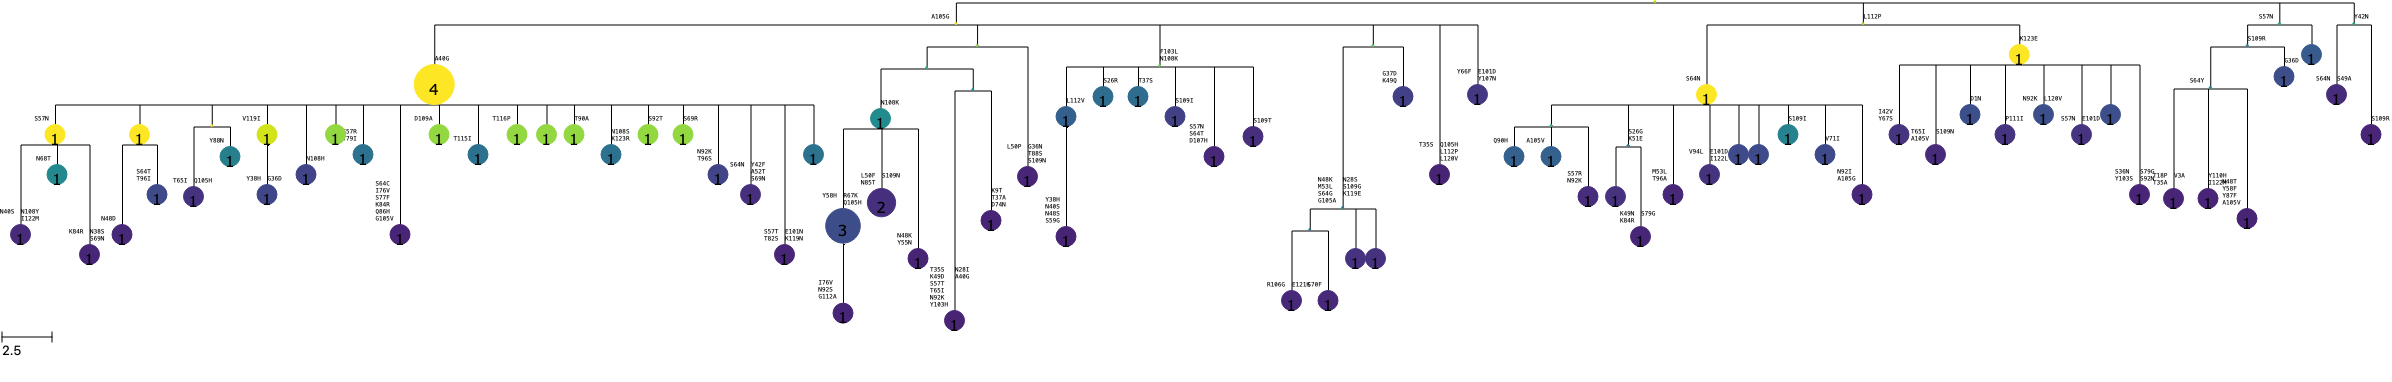

gc69HK


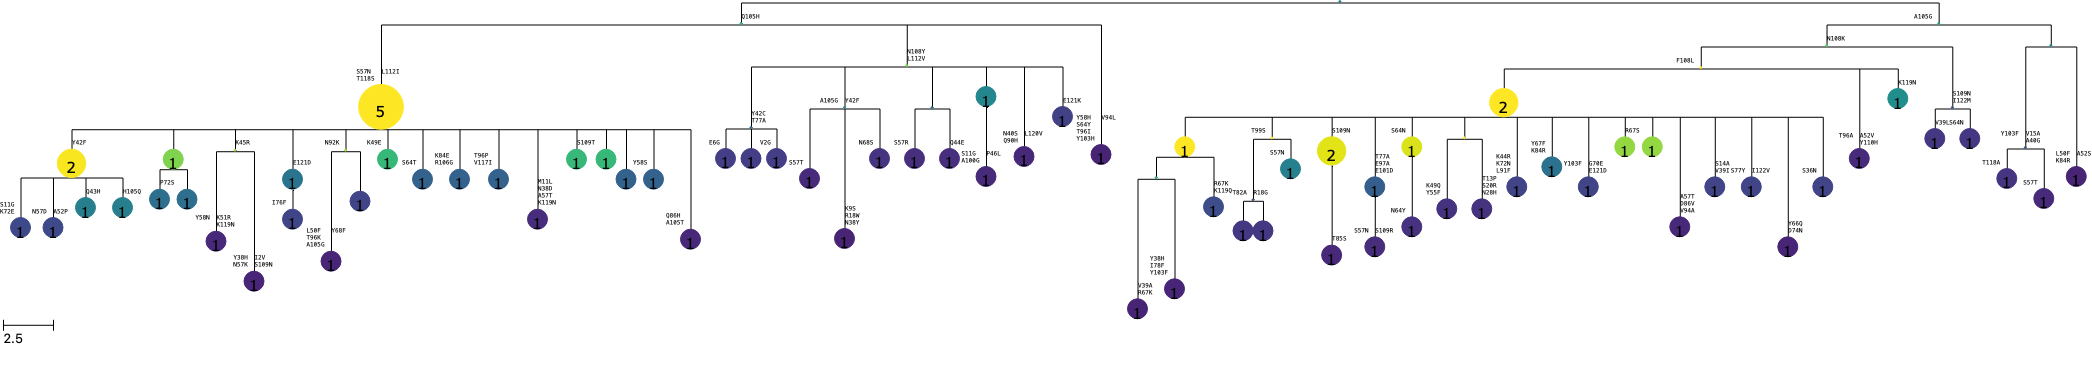

gc70HK


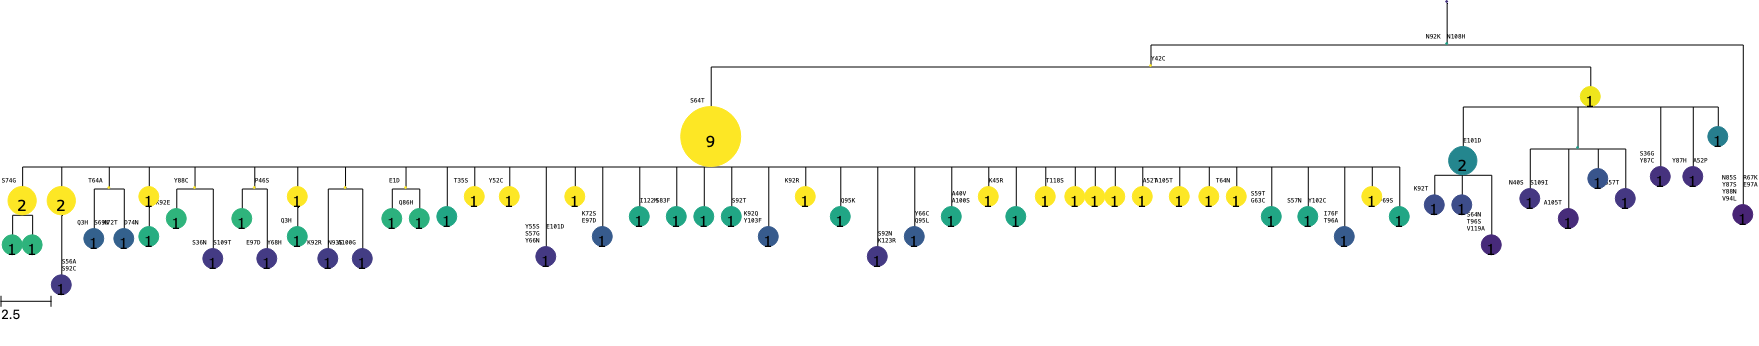

gc15HK


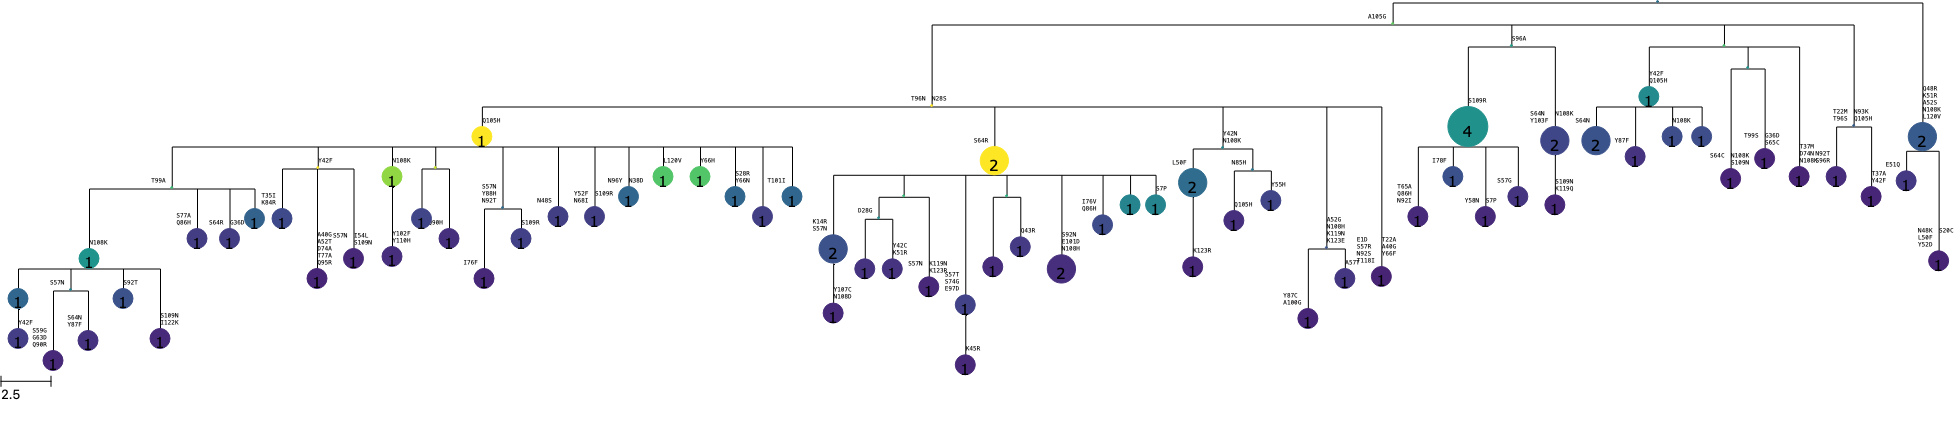

gc32HK


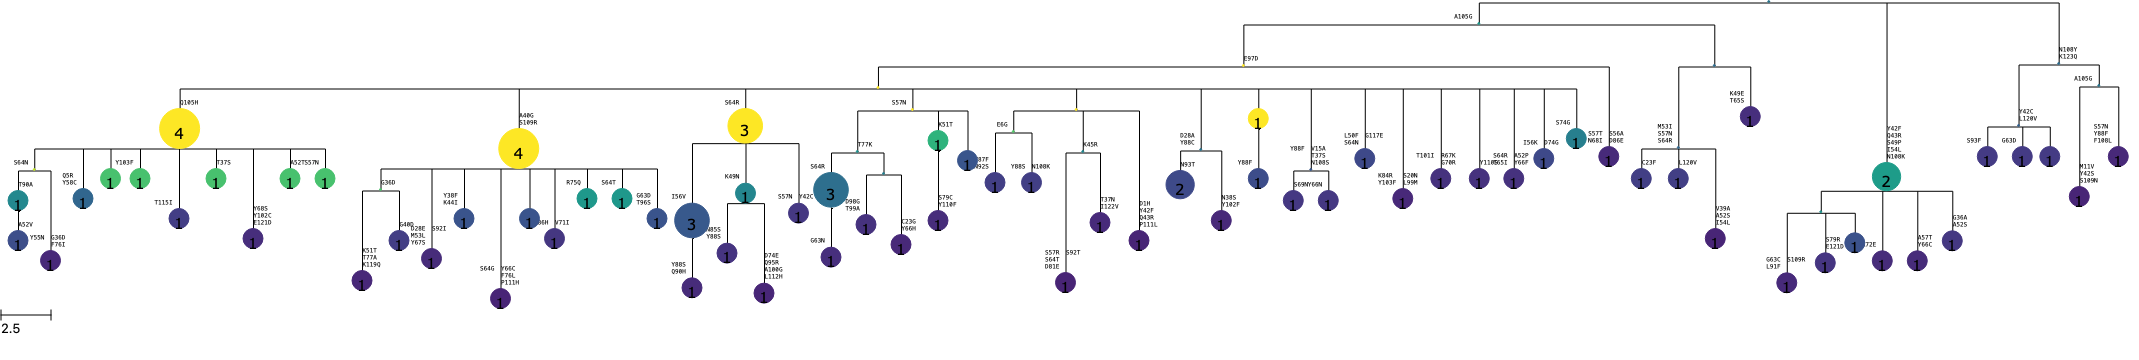

gc20HK-BC1


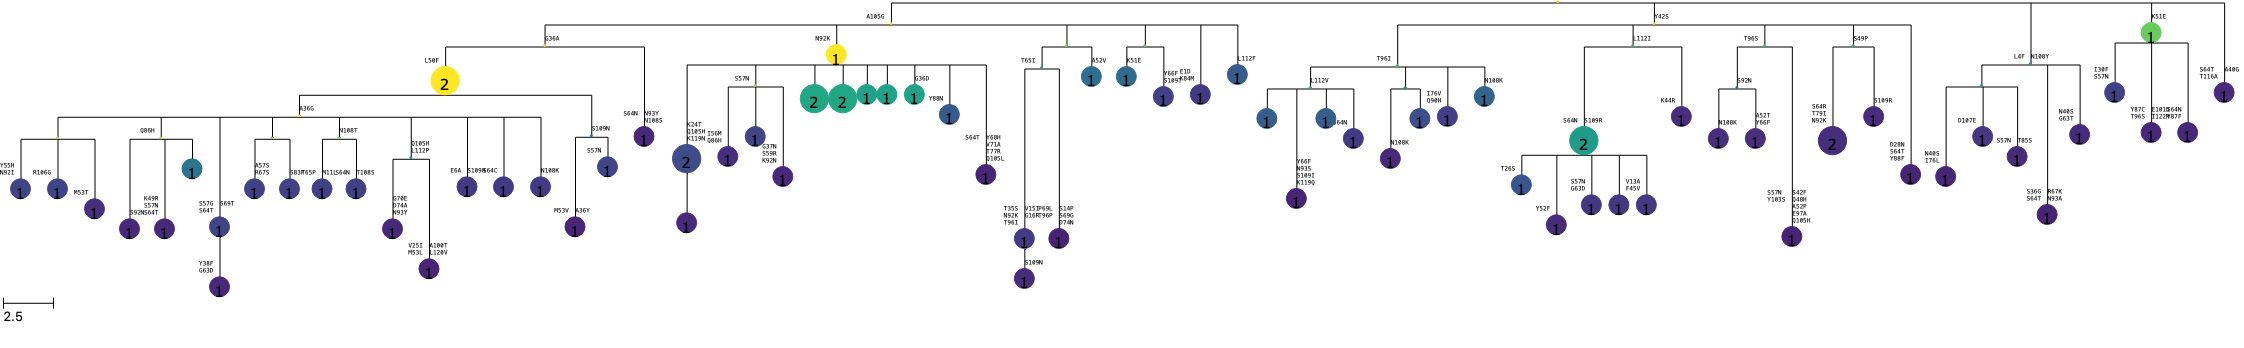

gc38HK-2


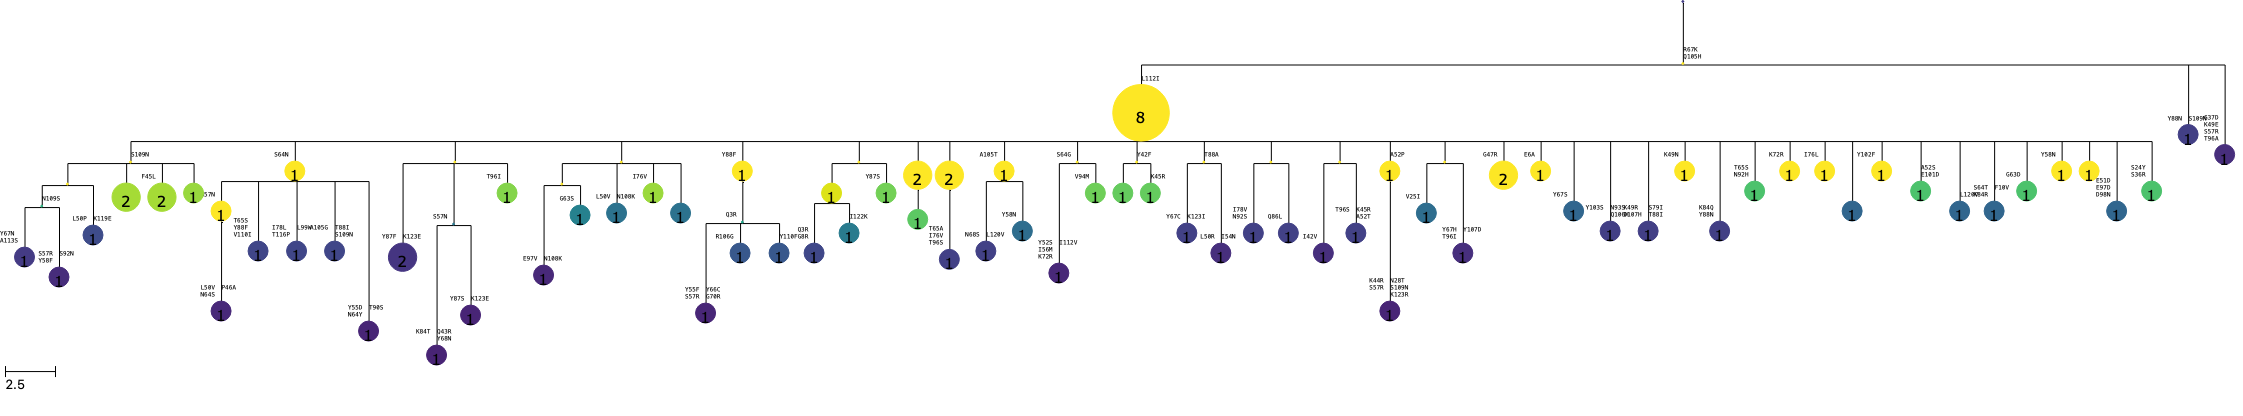

gc72HK-2


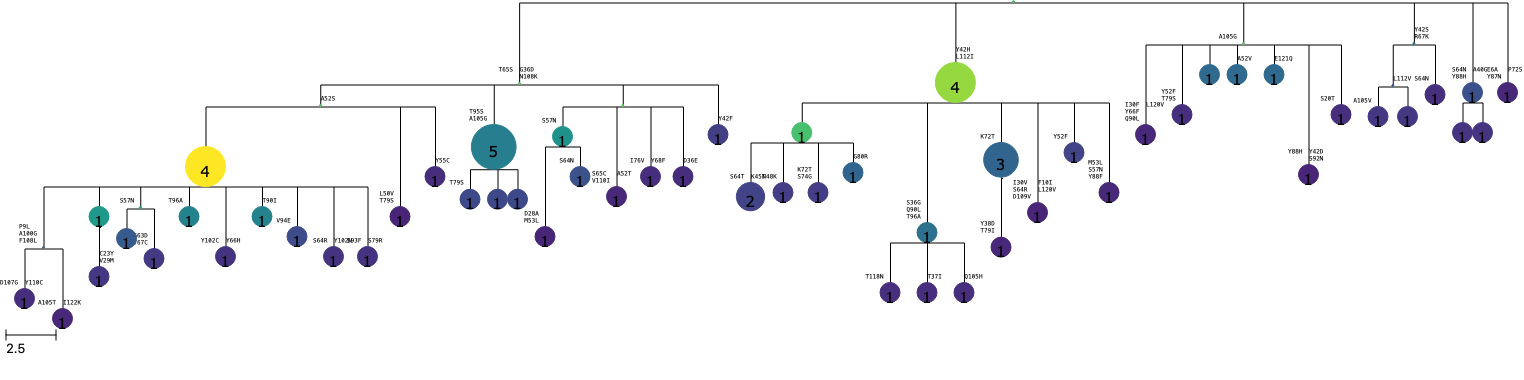

gc73HK-2


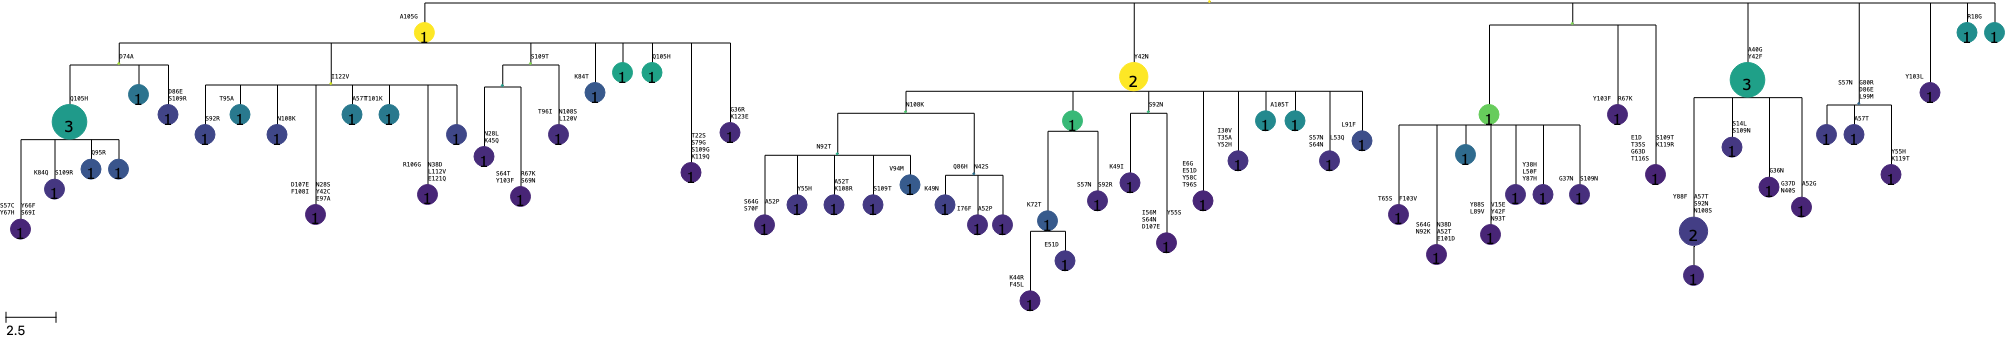

gc58HK-2


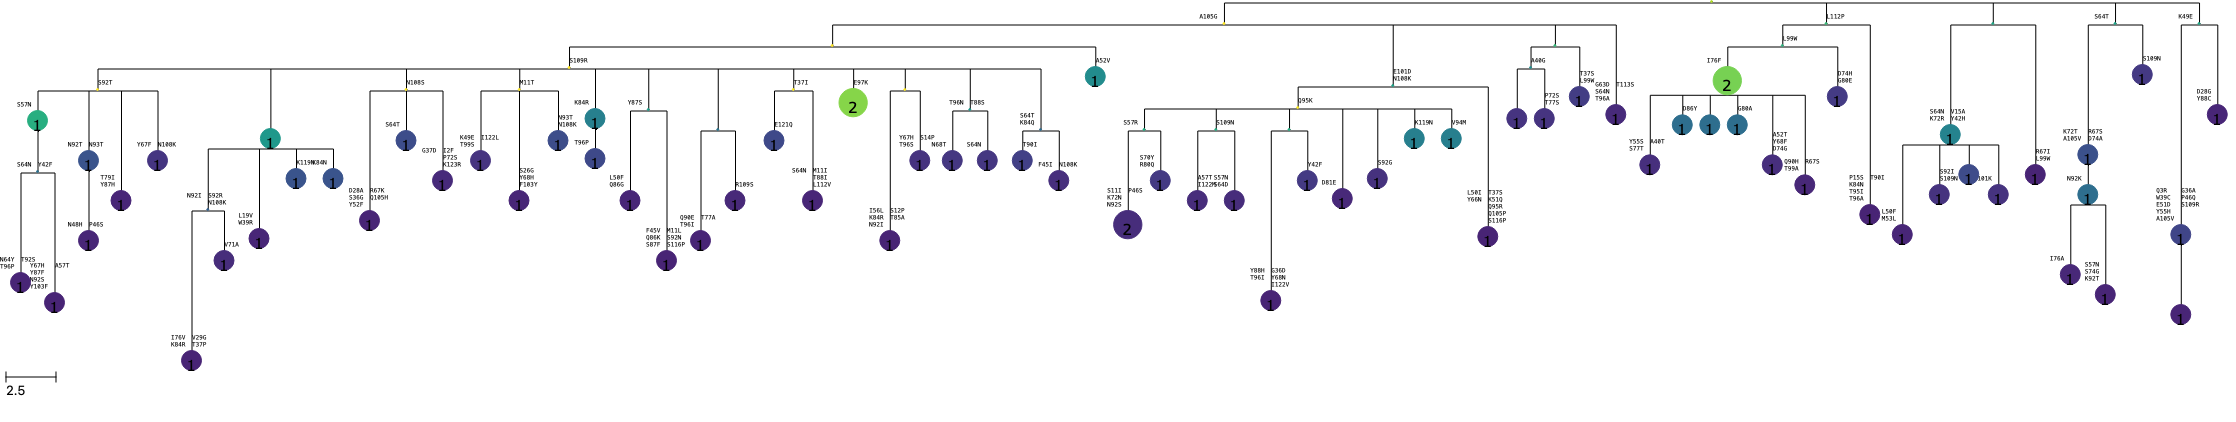

gc74HK-2


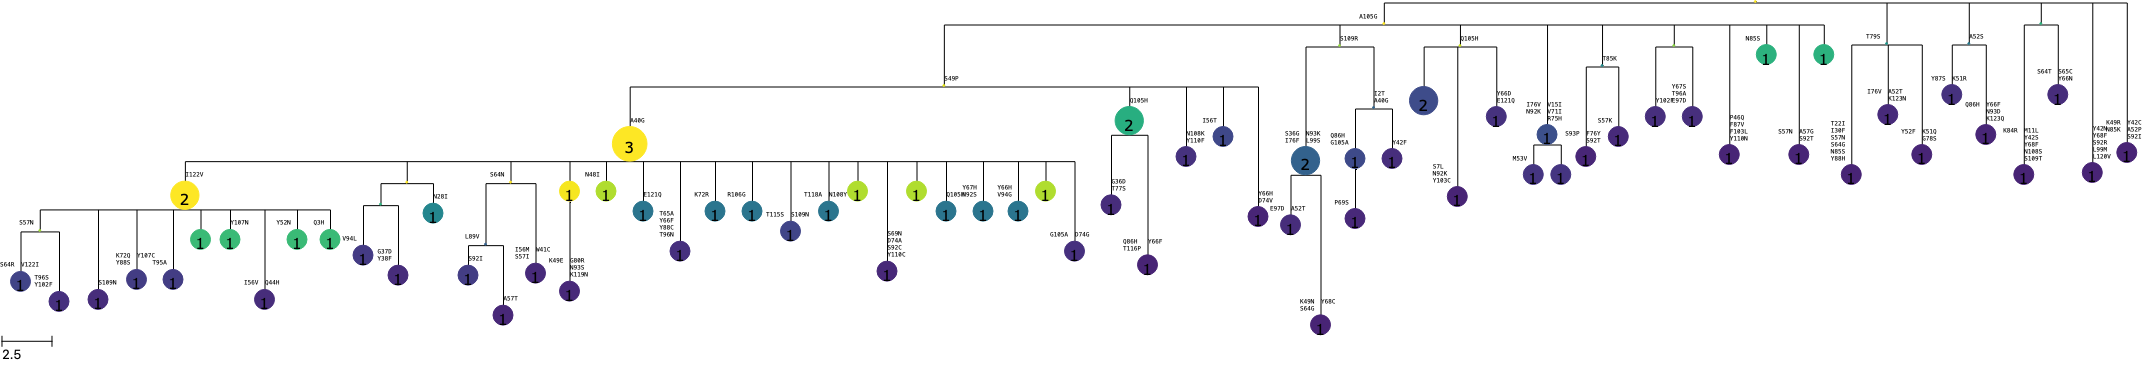

gc48HK-2


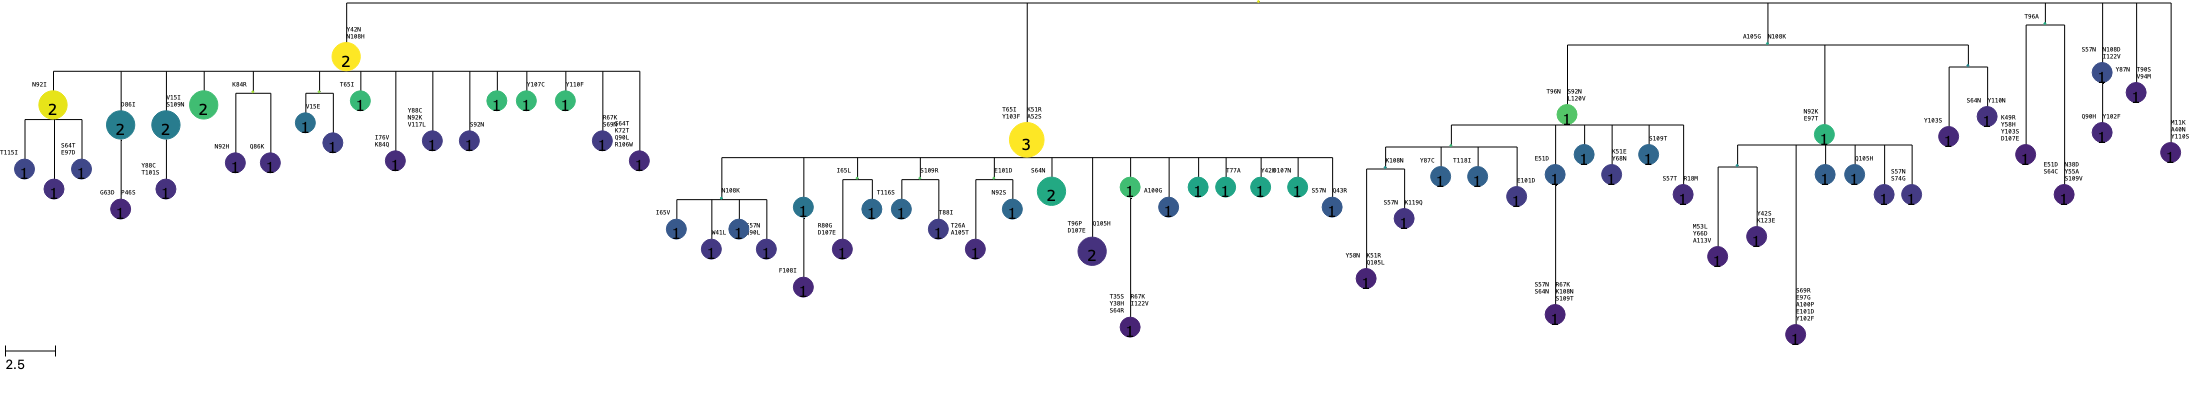

gc47HK-2


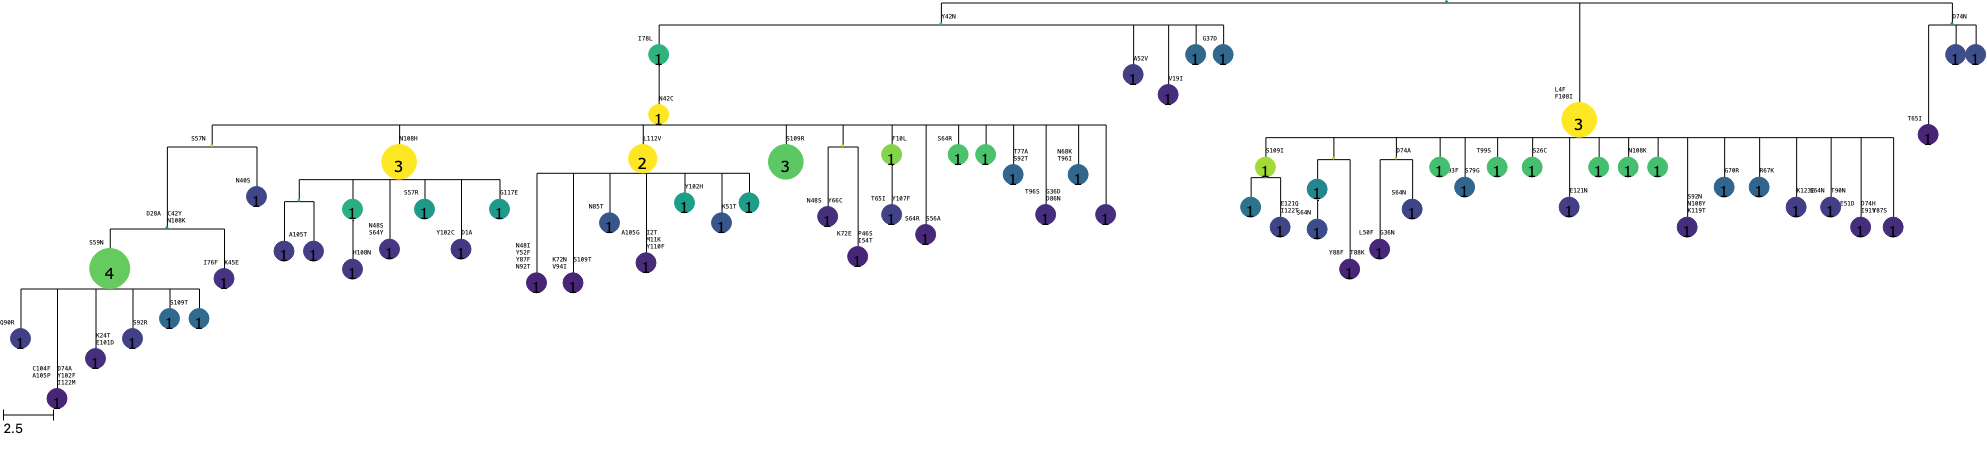

gc78HK-2


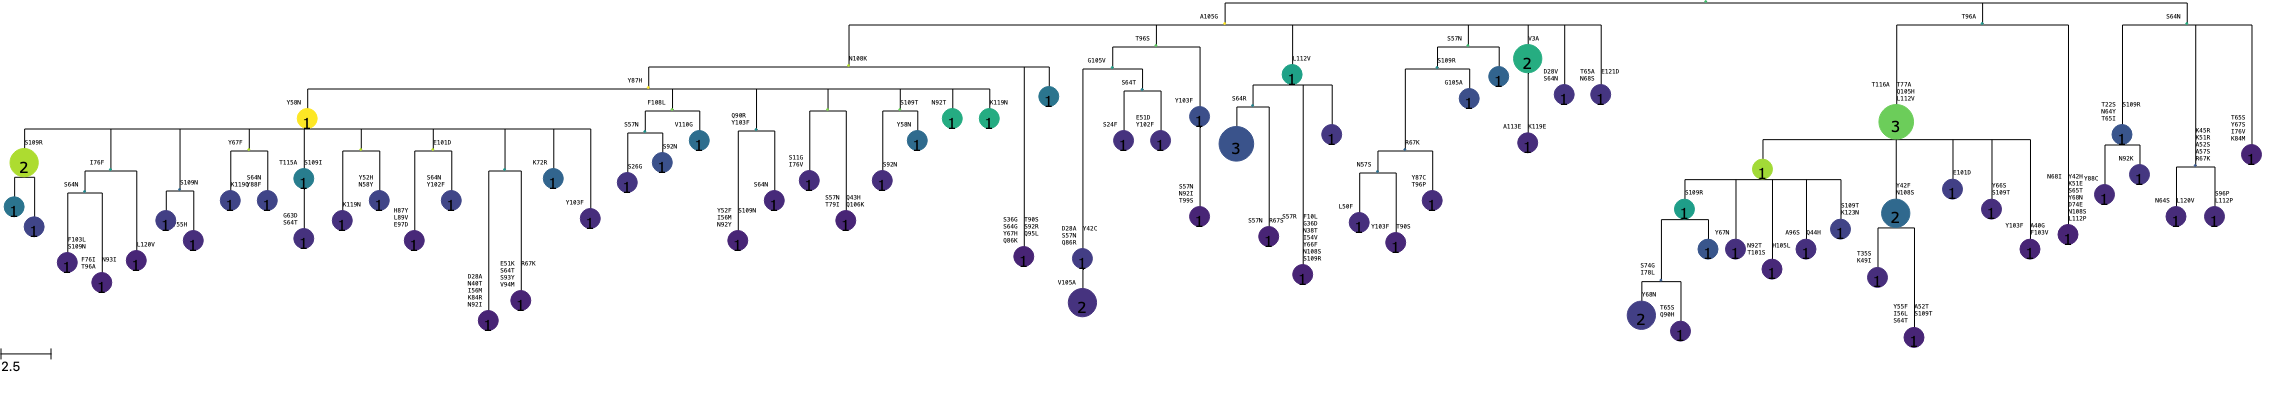

gc55HK-2


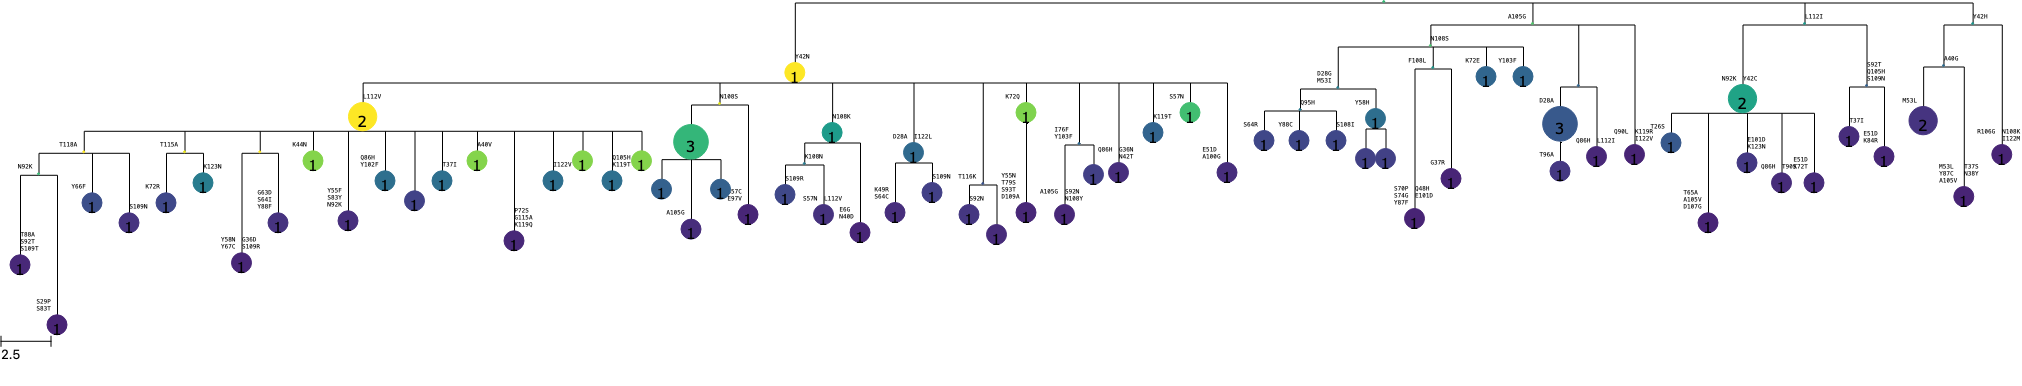

gc82HK-2


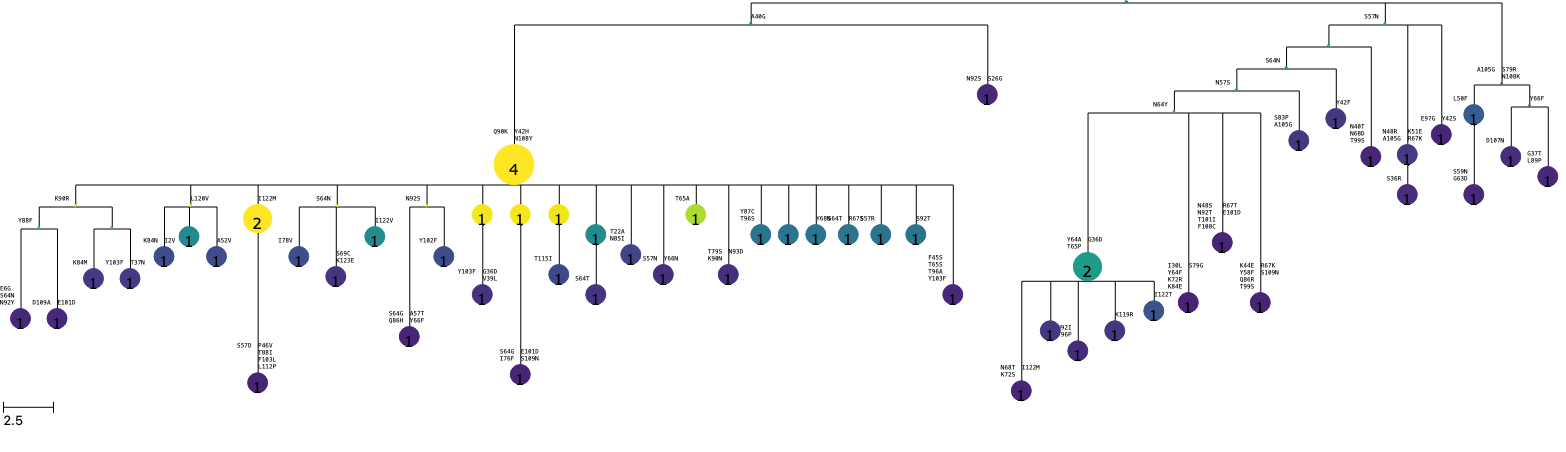

gc83HK-2


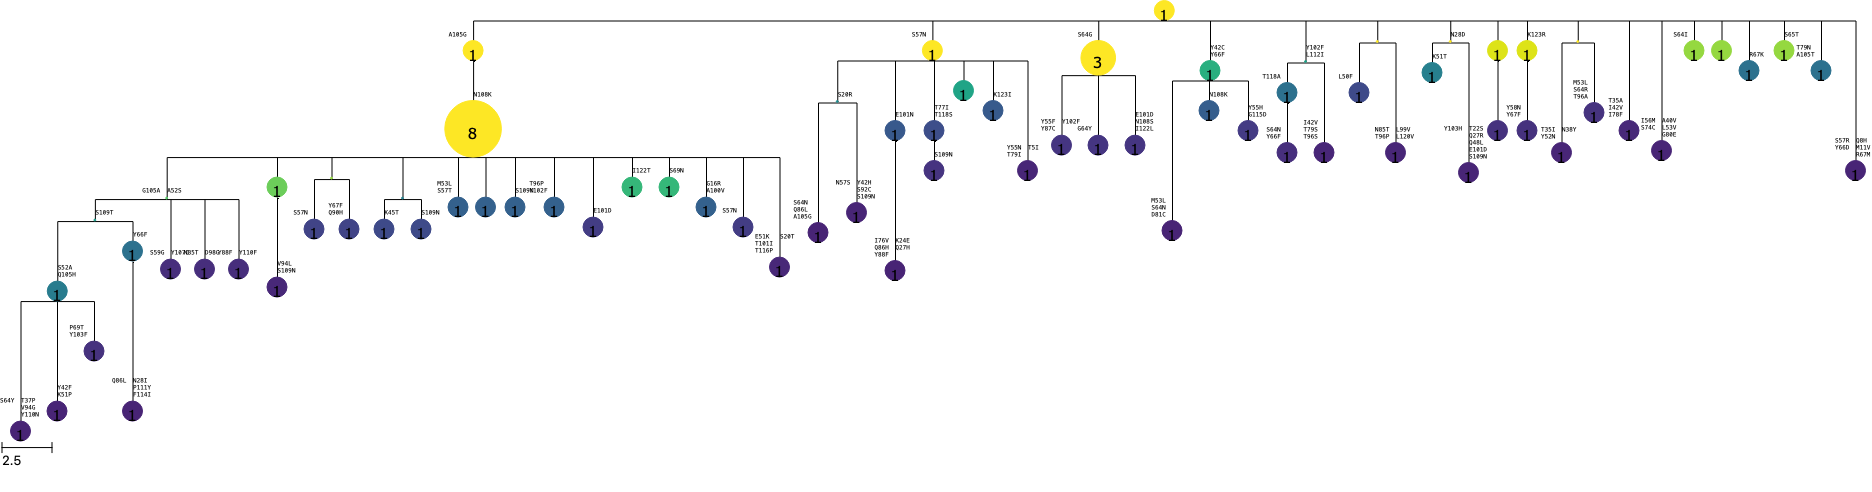

In [96]:
cmap = cm.get_cmap("viridis")
norm = Normalize(vmin=0, vmax=10)
for gc, tree in trees.items():
    print(gc)
    colormap = {node.name: to_hex(cmap(norm(node.LBI))) for node in tree.tree.traverse()}
    for file in (f"output/plots/colormapped_gctrees/{gc}.LBI.svg", "%%inline"):
        rendering = tree.render(file, scale=20,
                            colormap=colormap,
                            frame=igh_frame, frame2=igk_frame, chain_split=igk_idx,
                            position_map=igh_pos_map.site, position_map2=igk_pos_map.site)
    display(rendering)

In [17]:
mutability = pd.read_csv("mutability/MK_RS5NF_mutability.csv", index_col=0, squeeze=True)
substitution = pd.read_csv("mutability/MK_RS5NF_substitution.csv", index_col=0)

# mm = MutationModel("S5F/Mutability.csv", "S5F/Substitution.csv")
naive = tree.tree.sequence

def mutate(sequence):
    sequence_H = "NN" + sequence[:igk_idx] + "NN"
    sequence_K = "NN" + sequence[igk_idx:] + "NN"
    # mutabilities of each nucleotide
    contexts = [sequence_H[(i - 2) : (i + 3)]
                    for i in range(2, len(sequence_H) - 2)
                   ] + [sequence_K[(i - 2) : (i + 3)]
                        for i in range(2, len(sequence_K) - 2)
                       ]
    mutabilities = np.array([mutability[context] for context in contexts])
    i = np.random.choice(len(mutabilities), p=mutabilities / sum(mutabilities))
    sequence = sequence[:i] + np.random.choice(substitution.columns, p=substitution.loc[contexts[i]].fillna(0)) + sequence[(i + 1):]
    return sequence

In [178]:
sim_trees = defaultdict(list)
for gc, tree in trees.items():
    replicate = 1
    dead = False
    while replicate < 11:
        print(f"GC {gc}, replicate {replicate}", end="   \r")
        new_tree = tree.tree.copy()
        for node, node_new in zip(tree.tree.traverse(strategy="preorder"), new_tree.traverse(strategy="preorder")):
            assert node.name == node_new.name
            if not node.is_root():
                tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(node.sequence))).detach() - tdms_prediction_naive
                node.delta_bind = tdms_prediction[0].item()
                node.delta_expr = tdms_prediction[1].item()
                success = False
                closest = np.inf
                for tries in range(100):
                    node_new.sequence = node_new.up.sequence
                    for _ in range(int(node.dist)):
                        node_new.sequence = mutate(node_new.sequence)
                    tdms_prediction_new = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(node_new.sequence))).detach() - tdms_prediction_naive
                    node_new.delta_bind = tdms_prediction_new[0].item()
                    node_new.delta_expr = tdms_prediction_new[1].item()
                    delta = np.abs(node_new.delta_expr - node.delta_expr)
                    if delta < closest:
                        closest = delta
                        closest_seq = node_new.sequence
                        closes_delta_bind = node_new.delta_bind
                        closes_delta_expr = node_new.delta_expr
                    if delta < 0.1:
                        success = True
                        break
                if not success:
                    node_new.sequence = closest_seq
                    node_new.delta_bind = closes_delta_bind
                    node_new.delta_expr = closes_delta_expr
                    
        sim_trees[gc].append(new_tree)
        replicate += 1

In [81]:
# sim_df = pd.DataFrame()
# replicate = 1
# delta_expr_threshold = -3
# fitness_transition = 10
# while replicate < 100:
#     print(f"replicate {replicate + 1}", end="   \r")
#     sequence = naive
#     n_mutations = 0
#     rep_df = pd.DataFrame()
#     dead = False
#     while n_mutations < 11:
#         if n_mutations:
#             new_sequence = mutate(sequence)
#         else:
#             new_sequence = sequence
# #         igh_aa = aa(new_sequence[:igk_idx], igh_frame)
# #         igk_aa = aa(new_sequence[igk_idx:], igk_frame)
# #         igh_mutations = mutations(naive_igh_aa, igh_aa, igh_pos_map.site, "(H)")
# #         igk_mutations = mutations(naive_igk_aa, igk_aa, igk_pos_map.site, "(L)")
# #         all_mutations = igh_mutations + igk_mutations
# #         new_row = dms_df.loc[dms_df.mutation.isin(all_mutations), ["delta_bind", "delta_expr", "delta_psr"]].sum()
#         tdms_prediction = tdms_model(tdms_model.seq_to_binary(tree_nt_seq_to_dms_aa_seq(new_sequence))).detach() - tdms_prediction_naive
#         if np.random.rand() < expit(-fitness_transition * (tdms_prediction[1] - delta_expr_threshold)):
#             dead=True
#             break
#         sequence = new_sequence
#         new_row = pd.Series({"delta_bind": tdms_prediction[0].item(),
#                              "delta_expr": tdms_prediction[1].item(),
#                              "n_mutations": n_mutations,
#                              "replicate": replicate})
#         rep_df = rep_df.append(new_row, ignore_index=True, verify_integrity=True)
#         n_mutations += 1
#     if not dead:
#         sim_df = sim_df.append(rep_df, ignore_index=True, verify_integrity=True)
#         replicate += 1
# sim_df

In [114]:
# x = np.linspace(sim_df.delta_expr.min(), 0, 100)
# plt.plot(x, expit(-fitness_transition * (x - delta_expr_threshold)))
# plt.axvline(delta_expr_threshold, c="r")
# plt.xlabel("delta_expr")
# plt.ylabel("p(death)")
# plt.ylim(0, 1)
# plt.show()

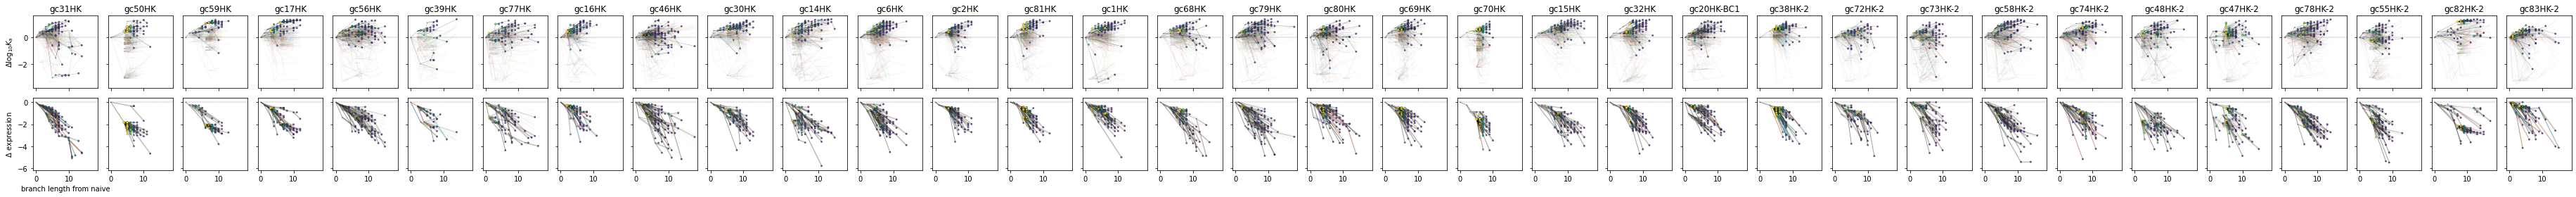

In [179]:
fig, axes = plt.subplots(2, len(trees), figsize=(1.5 * len(trees), 4), sharex=True, sharey="row")

for i, (phenotype, phenotype_label) in enumerate(zip(("delta_bind", "delta_expr", #"delta_psr"
                                                      ),
                                                     (r"$\Delta \log_{10} K_a$", r"$\Delta$ expression", #r"$\Delta$ polyspecificity"
                                                      )
                                                     )):
    for j, (gc, tree) in enumerate(trees.items()):
        points = []
        lines = []
        colors = []
        
        for node in tree.tree.traverse():
            points.append((tree.tree.get_distance(node),
                           getattr(node, phenotype),
                           1 + 5 * np.sqrt(node.abundance),
                           node.LBI))
            if node.up is not None:
                lines.append([(tree.tree.get_distance(node.up), getattr(node.up, phenotype)),
                              (tree.tree.get_distance(node), getattr(node, phenotype))])
            colors.append(node.LBI)

        sim_lines = []
        sim_colors = []
        for sim_idx, sim_tree in enumerate(sim_trees[gc]):
            for node in sim_tree.traverse():
                if node.up is not None:
                    sim_lines.append([(sim_tree.get_distance(node.up), getattr(node.up, phenotype)),
                                      (sim_tree.get_distance(node), getattr(node, phenotype))])
            sim_colors.append(f"C{sim_idx}")
        lc = mc.LineCollection(lines, colors="k", linewidths=0.3, alpha=0.5, zorder=3)
        sim_lc = mc.LineCollection(sim_lines, colors=sim_colors, linewidths=1, alpha=0.05, zorder=2)

        ax = axes[i, j]
        ax.axhline(0, c="k", ls="--", lw=0.25, zorder=1)
#         if phenotype == "delta_expr":
#             ax.axhline(delta_expr_threshold, c="r", ls="--", lw=0.25, zorder=1)
        ax.add_collection(lc)
        ax.add_collection(sim_lc)
        ax.scatter(*zip(*points), cmap=cmap, norm=norm, alpha=0.8, edgecolors="k", linewidths=0.2, zorder=4)
        if i == 0:
            ax.set_title(gc)
        ax.set_xlabel(None)
#         break
    axes[i, 0].set_ylabel(phenotype_label)
axes[-1, 0].set_xlabel("branch length from naive")
plt.tight_layout()
plt.savefig("output/plots/phenotype_trajectories.pdf")
plt.show()

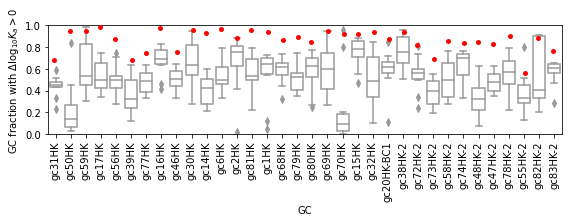

In [216]:
def tree_stat(tree):
    total = 0
    positive_delta_bind = 0
    for node in tree.traverse():
        total += node.abundance
        if node.delta_bind > 0:
            positive_delta_bind += node.abundance
    return positive_delta_bind / total

dat = []
for gc, tree in trees.items():
    dat.append([gc, False, tree_stat(tree.tree)])
    for rep_tree in sim_trees[gc]:
        dat.append([gc, True, tree_stat(rep_tree)])

stat_df = pd.DataFrame(dat, columns=["GC", "simulation", r"GC fraction with $\Delta\log_{10}K_a>0$"])    

plt.figure(figsize=(8, 3))
g = sns.boxplot(data=stat_df.loc[stat_df.simulation == True], x="GC", y=r"GC fraction with $\Delta\log_{10}K_a>0$", color="white")
sns.stripplot(data=stat_df.loc[stat_df.simulation == False], x="GC", y=r"GC fraction with $\Delta\log_{10}K_a>0$", color="r")
plt.ylim(0, 1)
for item in g.get_xticklabels():
    item.set_rotation(90)
plt.tight_layout()
plt.savefig("output/plots/selection_stat.pdf")
plt.show()

# Distributions of affinity effects of mutations on trees

Let's look at phenotypic effects of *sitewise* first-step mutations. We can do this sitewise because we are using an additive model. This would also work with a global epistasis model, with an additive latent space.

In [66]:
# def hit_counts(tree):
#     node_generator = tree.tree.traverse()
#     root = next(node)
#     root.add_feature("hit counts", [0] * len(naive_igh_aa))
#     naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
#     naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)
#     for node in node_generator:
#         igh_aa = aa(node.sequence[:igk_idx], igh_frame)
#         igk_aa = aa(node.sequence[igk_idx:], igk_frame)

In [101]:
# def mutation_effects(node):
#     if node.up is None:
#         return []
#     naive_igh_aa = aa(tree.tree.sequence[:igk_idx], igh_frame)
#     naive_igk_aa = aa(tree.tree.sequence[igk_idx:], igk_frame)
#     parent_igh_aa = aa(node.up.sequence[:igk_idx], igh_frame)
#     parent_igk_aa = aa(node.up.sequence[igk_idx:], igk_frame)
#     parent_igh_mutations = mutations(naive_igh_aa, parent_igh_aa, igh_pos_map.site, "(H)")
#     parent_igk_mutations = mutations(naive_igk_aa, parent_igk_aa, igk_pos_map.site, "(L)")
#     parent_mutations = parent_igh_mutations + parent_igk_mutations
    
#     igh_aa = aa(node.sequence[:igk_idx], igh_frame)
#     igk_aa = aa(node.sequence[igk_idx:], igk_frame)
#     igh_mutations = mutations(parent_igh_aa, igh_aa, igh_pos_map.site, "(H)")
#     igk_mutations = mutations(parent_igk_aa, igk_aa, igk_pos_map.site, "(L)")
#     node_mutations = igh_mutations + igk_mutations

#     for mutation in node_mutations:
#         match = [parent_mutation for parent_mutation in parent_mutations if parent_mutation[1:] == mutation[1:]]
# #         dms_df.mutation[dms_df.mutation.str[1:] == mutation[1:]]
#         assert len(match) < 2
#         print(match)
#         if len(match) = 0:
#             effect = dms_df.delta_bind[dms_df.mutation == mutation].iloc[0]
#             print(effect)
#         else:
#             print
# #         print(mutation)
# #         print(match)
    
# #     print(parent_igh_mutations + parent_igk_mutations)
# #     print(igh_mutations + igk_mutations)
    
# #     sum_delta_bind = dms_df.delta_bind[dms_df.mutation.isin(igh_mutations + igk_mutations)].sum()
    
#     return 